## **MARKET RECOMMENDER**

**Objetivo**

O objetivo deste produto é fornecer um serviço automatizado que recomenda leads para um usuário dado sua atual lista de clientes (Portfólio).

**Contextualização**

Algumas empresas gostariam de saber quem são as demais empresas em um determinado mercado (população) que tem maior probabilidade se tornarem seus próximos clientes. Ou seja, a sua solução deve encontrar no mercado quem são os leads mais aderentes dado as características dos clientes presentes no portfólio do usuário.

Além disso, sua solução deve ser agnóstica ao usuário. Qualquer usuário com uma lista de clientes que queira explorar esse mercado pode extrair valor do serviço.

Para o desafio, deverão ser consideradas as seguintes bases:

*   Mercado: Base com informações sobre as empresas do Mercado a ser considerado
*   Portfolio 1: Ids dos clientes da empresa 1
*   Portfolio 2: Ids dos clientes da empresa 2
*   Portfolio 3: Ids dos clientes da empresa 3


Arquivos disponíveis em: https://drive.google.com/drive/folders/13yoxj9ErdJRo9o6jR-Kwf-urmdg6KCC1?usp=sharing

GitHub da Aplicação: https://github.com/murilocaldeira/MarketRecommender.git

Demo da Aplicação: https://marketrecommender.herokuapp.com/


# **Imports**

In [1]:
# instalando o pandas profiling
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

     | 47.9MB 467kB/s
     |████████████████████████████████| 71kB 2.4MB/s 
     |████████████████████████████████| 61kB 5.0MB/s 
     |████████████████████████████████| 604kB 14.3MB/s 
     |████████████████████████████████| 3.1MB 15.2MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
     |████████████████████████████████| 296kB 42.6MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.9.0rc1-py2.py3-none-any.whl size=258106 sha256=faafbe9dfd5465f1edc1c5da5901f65fb763608d7a0278544dac77f6d1295391
  Stored in directory: /tmp/pip-ephem-wheel-cache-ogpr4nib/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27085 sha256=dc93748df22f1b2d224bf9b70f768bbb14e9d9df941eafba2f17340ef5d73ea0
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for imagehash: filename=ImageHash-4.1.0-py2.py3-none-any.whl size=2

In [2]:
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from pandas_profiling import ProfileReport
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [4]:
# Dados do mercado 
mkt = pd.read_csv('/gdrive/My Drive/CodenationRecommender/src/estaticos_market.csv')

# Dados dos portfólios
pt1 = pd.read_csv('/gdrive/My Drive/CodenationRecommender/src/estaticos_portfolio1.csv')
pt2 = pd.read_csv('/gdrive/My Drive/CodenationRecommender/src/estaticos_portfolio2.csv')
pt3 = pd.read_csv('/gdrive/My Drive/CodenationRecommender/src/estaticos_portfolio3.csv')

# **Análise Exploratória**

## Visualizando dados

In [5]:
mkt.head()


,Unnamed: 0,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,fl_sa,fl_epp,fl_mei,fl_ltda,dt_situacao,fl_st_especial,fl_email,fl_telefone,fl_rm,nm_divisao,nm_segmento,fl_spa,fl_antt,fl_veiculo,vl_total_tancagem,vl_total_veiculos_antt,vl_total_veiculos_leves,vl_total_veiculos_pesados,fl_optante_simples,qt_art,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,vl_total_tancagem_grupo,vl_total_veiculos_antt_grupo,vl_potenc_cons_oleo_gas,fl_optante_simei,sg_uf_matriz,de_saude_tributaria,de_saude_rescencia,...,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,qt_ex_funcionarios,qt_funcionarios_grupo,percent_func_genero_masc,percent_func_genero_fem,idade_ate_18,idade_de_19_a_23,idade_de_24_a_28,idade_de_29_a_33,idade_de_34_a_38,idade_de_39_a_43,idade_de_44_a_48,idade_de_49_a_53,idade_de_54_a_58,idade_acima_de_58,grau_instrucao_macro_analfabeto,grau_instrucao_macro_escolaridade_fundamental,grau_instrucao_macro_escolaridade_media,grau_instrucao_macro_escolaridade_superior,grau_instrucao_macro_desconhecido,total,meses_ultima_contratacaco,qt_admitidos_12meses,qt_desligados_12meses,qt_desligados,qt_admitidos,media_meses_servicos_all,max_meses_servicos_all,min_meses_servicos_all,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
0,0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,14.457534,10 a 15,False,False,False,False,False,2005-03-25,False,True,True,SIM,CONSTRUCAO DE EDIFICIOS,CONSTRUCAO,False,False,False,NaN,NaN,NaN,NaN,True,8.0,0.0,0.0,NaN,NaN,NaN,False,RN,VERDE,ACIMA DE 1 ANO,...,3132172.8,3132172.8,119.0,26.0,100.0,0.0,NaN,1.0,4.0,6.0,5.0,3.0,4.0,2.0,NaN,1.0,NaN,1.0,25.0,NaN,NaN,26.0,19.166667,0.0,0.0,119.0,145.0,13.309195,93.266667,-0.933333,43.738462,93.266667,19.166667,26.0,26.0,27.0,0.0,-3.703704,0.0,0
1,1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,SERVICOS DE ALOJAMENTO/ALIMENTACAO,SERVIÇO,1.463014,1 a 5,False,False,False,True,False,2017-05-12,False,True,True,SIM,ALIMENTACAO,ALOJAMENTO E ALIMENTACAO,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,PI,CINZA,ATE 1 ANO,...,210000.0,210000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,"TRANSPORTE, ARMAZENAGEM E CORREIO",SERVIÇO,7.093151,5 a 10,False,False,False,True,False,2011-09-26,False,False,True,SIM,TRANSPORTE TERRESTRE,TRANSPORTE ARMAZENAGEM E CORREIO,False,False,False,NaN,NaN,NaN,NaN,True,NaN,0.0,0.0,NaN,NaN,NaN,True,AM,AMARELO,ACIMA DE 1 ANO,...,50000.0,50000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,SERVICOS DIVERSOS,SERVIÇO,6.512329,5 a 10,False,False,False,False,False,2012-04-25,False,True,True,SIM,REPARACAO E MANUTENCAO DE EQUIPAMENTOS DE INFO...,OUTRAS ATIVIDADES DE SERVICOS,False,False,False,NaN,NaN,NaN,NaN,True,NaN,0.0,0.0,NaN,NaN,NaN,False,AM,AMARELO,ACIMA DE 1 ANO,...,210000.0,210000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,True,EMPRESARIO INDIVIDUAL,RN,OUTROS,"SERVICOS PROFISSIONAIS, TECNICOS E CIENTIFICOS",SERVIÇO,3.200000,1 a 5,False,False,False,False,False,2015-08-17,False,True,True,SIM,SERVICOS DE ARQUITETURA E ENGENHARIA TESTES E ...,ATIVIDADES PROFISSIONAIS CIENTIFICAS E TECNICAS,False,False,False,NaN,NaN,NaN,NaN

In [6]:
pt1.head()


,Unnamed: 0,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,fl_sa,fl_epp,fl_mei,fl_ltda,dt_situacao,fl_st_especial,fl_email,fl_telefone,fl_rm,nm_divisao,nm_segmento,fl_spa,fl_antt,fl_veiculo,vl_total_tancagem,vl_total_veiculos_antt,vl_total_veiculos_leves,vl_total_veiculos_pesados,fl_optante_simples,qt_art,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,vl_total_tancagem_grupo,vl_total_veiculos_antt_grupo,vl_potenc_cons_oleo_gas,fl_optante_simei,sg_uf_matriz,de_saude_tributaria,de_saude_rescencia,...,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,qt_ex_funcionarios,qt_funcionarios_grupo,percent_func_genero_masc,percent_func_genero_fem,idade_ate_18,idade_de_19_a_23,idade_de_24_a_28,idade_de_29_a_33,idade_de_34_a_38,idade_de_39_a_43,idade_de_44_a_48,idade_de_49_a_53,idade_de_54_a_58,idade_acima_de_58,grau_instrucao_macro_analfabeto,grau_instrucao_macro_escolaridade_fundamental,grau_instrucao_macro_escolaridade_media,grau_instrucao_macro_escolaridade_superior,grau_instrucao_macro_desconhecido,total,meses_ultima_contratacaco,qt_admitidos_12meses,qt_desligados_12meses,qt_desligados,qt_admitidos,media_meses_servicos_all,max_meses_servicos_all,min_meses_servicos_all,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
0,0,dabe79bec87c88ae04e869bf6bd321ee5e1893cecf6625...,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,COMERCIO VAREJISTA,COMERCIO,0.646575,<= 1,False,False,False,True,False,2018-03-06,False,False,False,NAO,COMERCIO VAREJISTA,COMERCIO; REPARACAO DE VEICULOS AUTOMOTORES E ...,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,PI,CINZA,SEM INFORMACAO,...,210000.0,210000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,32e5f4e10932153a7ba869cb0386e7e02d49d2461046b8...,False,EMPRESARIO INDIVIDUAL,MA,OUTROS,COMERCIO VAREJISTA,COMERCIO,6.586301,5 a 10,False,False,False,False,False,2012-03-29,False,True,True,NAO,COMERCIO VAREJISTA,COMERCIO; REPARACAO DE VEICULOS AUTOMOTORES E ...,False,False,False,NaN,NaN,NaN,NaN,False,NaN,0,0,NaN,NaN,NaN,False,MA,VERDE,ACIMA DE 1 ANO,...,210000.0,1000915.2,6.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.666667,0.0,0.0,6.0,6.0,22.427778,47.633333,3.966667,NaN,NaN,NaN,0.0,0.0,2.0,NaN,-100.0,0.0,4
2,2,a95d6f30bba445bd3d6b0c5b36f865b38ec01d17336090...,True,EMPRESARIO INDIVIDUAL,MA,OUTROS,COMERCIO VAREJISTA,COMERCIO,8.010959,5 a 10,False,False,False,True,False,2010-10-26,False,False,False,SIM,COMERCIO VAREJISTA,COMERCIO; REPARACAO DE VEICULOS AUTOMOTORES E ...,False,False,False,NaN,NaN,NaN,NaN,True,NaN,0,0,NaN,NaN,NaN,True,MA,AZUL,ACIMA DE 1 ANO,...,50000.0,50000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,3,6cb309685cea0b6d2988818792ec2e6fcb2bd02e0afa9e...,True,EMPRESARIO INDIVIDUAL,RN,OUTROS,COMERCIO VAREJISTA,COMERCIO,20.863014,> 20,False,False,False,False,False,2005-11-03,False,False,False,NAO,COMERCIO VAREJISTA,COMERCIO; REPARACAO DE VEICULOS AUTOMOTORES E ...,False,False,False,NaN,NaN,NaN,NaN,True,NaN,0,0,NaN,NaN,NaN,True,RN,VERDE,ACIMA DE 1 ANO,...,50000.0,50000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,4,f72aa7fa6787b0a5a1c88885b6120850df8ee0f71adc25...,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,COMERCIO VAREJISTA,COMERCIO,18.726027,15 a 20,False,False,False,False,False,2005-11-03,False,True,True,SIM,COMERCIO VAREJISTA,COMERCIO; REPARACAO DE VEICULOS AUTOMOTORES E ...,False,False,False,NaN,NaN,NaN,NaN,True,1.0,0,0,NaN,NaN,NaN,False,RN,VERDE,ACIMA DE 1 ANO,...,3029140.8,5872824.0,

In [7]:
pt2.head()


,Unnamed: 0,id
0,0,09e95c1a84049001d086470a8f320a19b076f955a89122...
1,1,dc9d155f5bcd3172031e2ec9431786e8871ff4b0ff4728...
2,2,16843c9ffb920170477118933798510d8d5f00f5c56c12...
3,3,ff045934d90aab184dd15e66daf3b3c97193bda5449298...
4,4,a0ce528caab2c62497a548d0ebd9e935143ef81ed7dbf0...


In [8]:
pt3.head()

,Unnamed: 0,id
0,0,bb61c09449a1c1f8b78955d8b7a7f73599e78358993fe2...
1,1,16843c9ffb920170477118933798510d8d5f00f5c56c12...
2,2,1b8d092daff12bed8b3c2ab93bf5df2921865a68aca185...
3,3,3aafa3a1f12f483740a52956af100223333d0e3c79bf2c...
4,4,c60431fbca90067f105570e1e8a684bcd7048205bbf6c4...


In [9]:
mkt.describe()

,Unnamed: 0,idade_empresa_anos,vl_total_tancagem,vl_total_veiculos_antt,vl_total_veiculos_leves,vl_total_veiculos_pesados,qt_art,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,vl_total_tancagem_grupo,vl_total_veiculos_antt_grupo,vl_potenc_cons_oleo_gas,nu_meses_rescencia,vl_frota,empsetorcensitariofaixarendapopulacao,qt_socios,qt_socios_pf,qt_socios_pj,idade_media_socios,idade_maxima_socios,idade_minima_socios,qt_socios_st_regular,qt_socios_st_suspensa,qt_socios_masculino,qt_socios_feminino,qt_socios_pep,qt_alteracao_socio_total,qt_alteracao_socio_90d,qt_alteracao_socio_180d,qt_alteracao_socio_365d,qt_socios_pj_ativos,qt_socios_pj_nulos,qt_socios_pj_baixados,qt_socios_pj_suspensos,qt_socios_pj_inaptos,vl_idade_media_socios_pj,vl_idade_maxima_socios_pj,vl_idade_minima_socios_pj,qt_coligados,qt_socios_coligados,...,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,qt_ex_funcionarios,qt_funcionarios_grupo,percent_func_genero_masc,percent_func_genero_fem,idade_ate_18,idade_de_19_a_23,idade_de_24_a_28,idade_de_29_a_33,idade_de_34_a_38,idade_de_39_a_43,idade_de_44_a_48,idade_de_49_a_53,idade_de_54_a_58,idade_acima_de_58,grau_instrucao_macro_analfabeto,grau_instrucao_macro_escolaridade_fundamental,grau_instrucao_macro_escolaridade_media,grau_instrucao_macro_escolaridade_superior,grau_instrucao_macro_desconhecido,total,meses_ultima_contratacaco,qt_admitidos_12meses,qt_desligados_12meses,qt_desligados,qt_admitidos,media_meses_servicos_all,max_meses_servicos_all,min_meses_servicos_all,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
count,462298.00000,462298.000000,280.000000,176.000000,30684.000000,30684.000000,6590.000000,460371.000000,460371.000000,1760.000000,336.000000,3683.000000,417022.000000,2.419000e+04,318469.000000,347207.000000,347207.000000,347207.000000,310696.000000,310696.000000,310696.000000,307381.000000,3251.000000,195115.000000,145029.000000,6743.000000,0.0,0.0,0.0,0.0,4544.000000,4544.000000,4544.000000,4544.000000,4544.000000,4544.000000,4544.000000,4544.000000,65391.000000,65391.000000,...,4.347850e+05,4.347850e+05,115254.000000,1.152630e+05,75942.000000,75942.000000,2906.000000,25890.000000,38895.000000,40143.000000,36729.000000,30408.000000,24290.000000,19037.000000,13975.000000,11026.000000,1884.000000,24896.000000,67797.000000,22727.000000,0.0,75942.000000,103574.000000,103574.000000,103574.000000,103574.000000,103574.000000,103560.000000,103560.000000,103560.000000,76261.000000,76261.000000,76261.000000,103574.000000,103574.000000,103574.000000,73888.000000,74014.000000,103574.000000,462298.000000
mean,231148.50000,9.948677,32.014286,3.818182,2.244329,1.177813,5.769044,3.591801,48.699177,134.597159,15.934524,15.892131,25.007247,1.694226e+05,1308.005725,1.496326,1.476681,0.019645,42.816452,44.344131,41.355225,1.396082,1.048600,1.353925,1.107117,5.992437,NaN,NaN,NaN,NaN,1.453785,0.007262,0.013424,0.004842,0.021787,15.633042,17.667913,13.741865,5.744093,11.110336,...,8.020911e+05,3.367205e+08,24.838418,1.109122e+04,55.699435,44.300577,2.197866,3.544998,4.247384,5.158932,5.634186,5.664661,5.480939,5.758155,6.115063,8.240522,2.248938,8.246465,11.496128,12.310336,NaN,16.706447,43.192861,2.101029,1.853148,27.698110,40.022679,41.965123,155.569411,16.200192,58.060498,96.661983,36.258851,12.324570,12.178529,14.343329,3.097607,-5.834288,9.510699,28.737044
std,133454.08171,9.615664,81.280168,6.797555,9.572536,6.589059,25.450950,72.600352,1206.696804,683.774506,29.708663,75.230681,9.679799,8.549075e+05,1161.889222,3.276626,3.258079,0.195166,12.626447,13.930385,12.514921,2.578793,0.234239,2.848980,0.840194,14.675005,NaN,NaN,NaN,NaN,0.840884,0.084919,0.124291,0.072522,0.177320,12.566365,14.650236,12.050708,24.271199,64.630753,...,3.099979e+07,7.114614e+09,192.458811,1.390161e+05,39.044407,39.044406,6.295785,20.727621,18.338771,30.416582,47.295036,53.753

## Valores Missing

Visto que existem muitos dados faltantes, vou adotar a estratégia de manter apenas colunas com menos de 20% de valores nulos.

In [10]:
df_missing = pd.DataFrame({'colunas': mkt.columns, 'tipos': mkt.dtypes,'NA #': mkt.isna().sum(), 'NA %': (mkt.isna().sum() / mkt.shape[0]) * 100})

df_missing

,colunas,tipos,NA #,NA %
Unnamed: 0,Unnamed: 0,int64,0,0.000000
id,id,object,0,0.000000
fl_matriz,fl_matriz,bool,0,0.000000
de_natureza_juridica,de_natureza_juridica,object,0,0.000000
sg_uf,sg_uf,object,0,0.000000
...,...,...,...,...
qt_funcionarios_24meses,qt_funcionarios_24meses,float64,358724,77.595836
tx_crescimento_12meses,tx_crescimento_12meses,float64,388410,84.017236
tx_crescimento_24meses,tx_crescimento_24meses,float64,388284,83.989980
tx_rotatividade,tx_rotatividade,float64,358724,77.595836


In [11]:
colunas_persist = list(df_missing[df_missing['NA %'] <= 20]['colunas'])
mkt = mkt[colunas_persist]
mkt.columns

Index(['Unnamed: 0', 'id', 'fl_matriz', 'de_natureza_juridica', 'sg_uf',
       'natureza_juridica_macro', 'de_ramo', 'setor', 'idade_empresa_anos',
       'idade_emp_cat', 'fl_me', 'fl_sa', 'fl_epp', 'fl_mei', 'fl_ltda',
       'dt_situacao', 'fl_st_especial', 'fl_email', 'fl_telefone', 'fl_rm',
       'nm_divisao', 'nm_segmento', 'fl_spa', 'fl_antt', 'fl_veiculo',
       'fl_optante_simples', 'vl_total_veiculos_pesados_grupo',
       'vl_total_veiculos_leves_grupo', 'fl_optante_simei', 'sg_uf_matriz',
       'de_saude_tributaria', 'de_saude_rescencia', 'nu_meses_rescencia',
       'de_nivel_atividade', 'fl_simples_irregular', 'nm_meso_regiao',
       'nm_micro_regiao', 'fl_passivel_iss', 'de_faixa_faturamento_estimado',
       'de_faixa_faturamento_estimado_grupo', 'vl_faturamento_estimado_aux',
       'vl_faturamento_estimado_grupo_aux', 'qt_filiais'],
      dtype='object')

## Seleção de Features
Nesta etapa nosso objetivo é conhecer mais a fundo os dados que estamos trabalhando.

Farei uso da ferramenta Pandas Profiling para essa etapa:

In [12]:
# executando o profile
profile_mkt = ProfileReport(mkt, title='Relatório - Dados do Mercado', html={'style':{'full_width':True}})

In [13]:
profile_mkt

Output hidden; open in https://colab.research.google.com to view.

In [14]:
# salvando o relatório para análise com melhor visualização e manipulação
profile_mkt.to_file(output_file="/gdrive/My Drive/CodenationRecommender/src/Relatorio01.html")

Analisando o relatório gerado pelo pandas profile, cheguei nas seguintes conclusões para exclusão das features: 

	'natureza_juridica_macro', alta correlação com a de_natureza_juridica
	'setor', alta correlação com de_ramo
	'idade_empresa_anos', utilizarei apenas a idade por categoria
	'dt_situacao', muitos valores distintos
	'fl_st_especial', exemplo muito desbalanceado quase total com mesmos valores
	'fl_email',  considerado indiferente para modelo
	'fl_telefone', considerado indiferente para modelo
	'nm_divisao', alta correlação com de_ramo
	'nm_segmento', alta correlação com de_ramo
	'fl_me', a grande maioria é mei no mercado
	'fl_sa', a grande maioria é mei no mercado
	'fl_epp', a grande maioria é mei no mercado
	'fl_mei', a grande maioria é mei no mercado
	'fl_ltda', a grande maioria é mei no mercado
	'fl_spa', exemplo muito desbalanceado quase total com mesmos valores
	'fl_antt', exemplo muito desbalanceado quase total com mesmos valores
	'fl_veiculo',exemplo muito desbalanceado quase total com mesmos valores
	'fl_optante_simples', relacionado com MEI e ME, pouco afetaria o modelo
	'vl_total_veiculos_pesados_grupo', muitos zeros
	'vl_total_veiculos_leves_grupo', muitos zeros
	'fl_optante_simei', relacionado com MEI e ME, pouco afetaria o modelo
	'sg_uf_matriz', correlacioando com seg_uf 
	'de_saude_rescencia', relacionado a saude tributaria
	'nu_meses_rescencia',  relacionado a saude tributaria
	'fl_simples_irregular',  relacionado a saude tributaria
	'nm_meso_regiao', correlacioando com seg_uf
	'nm_micro_regiao', correlacioando com seg_uf
	'fl_passivel_iss', relacionado ao tipo de empresa
	'de_faixa_faturamento_estimado_grupo', relacionado ao faturamento da propria empresa/filial
	'vl_faturamento_estimado_grupo_aux',  relacionado ao faturamento da propria empresa/filial
	'qt_filiais', muitos zeros alem de ter reclação com campo fl_matriz 

# **Tratamento de Features**

In [15]:
colunas_persist = ['id', 
'fl_matriz', 
'de_natureza_juridica', 
'sg_uf',       
'de_ramo', 
'idade_emp_cat', 
'fl_rm',
'de_saude_tributaria', 
'de_nivel_atividade', 
'de_faixa_faturamento_estimado',
'vl_faturamento_estimado_aux']

mkt = mkt[colunas_persist]
mkt.columns

Index(['id', 'fl_matriz', 'de_natureza_juridica', 'sg_uf', 'de_ramo',
       'idade_emp_cat', 'fl_rm', 'de_saude_tributaria', 'de_nivel_atividade',
       'de_faixa_faturamento_estimado', 'vl_faturamento_estimado_aux'],
      dtype='object')

In [16]:
mkt.head()

,id,fl_matriz,de_natureza_juridica,sg_uf,de_ramo,idade_emp_cat,fl_rm,de_saude_tributaria,de_nivel_atividade,de_faixa_faturamento_estimado,vl_faturamento_estimado_aux
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,True,SOCIEDADE EMPRESARIA LIMITADA,RN,INDUSTRIA DA CONSTRUCAO,10 a 15,SIM,VERDE,ALTA,"DE R$ 1.500.000,01 A R$ 4.800.000,00",3132172.8
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,True,EMPRESARIO INDIVIDUAL,PI,SERVICOS DE ALOJAMENTO/ALIMENTACAO,1 a 5,SIM,CINZA,BAIXA,"DE R$ 81.000,01 A R$ 360.000,00",210000.0
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,True,EMPRESARIO INDIVIDUAL,AM,"TRANSPORTE, ARMAZENAGEM E CORREIO",5 a 10,SIM,AMARELO,MEDIA,"ATE R$ 81.000,00",50000.0
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,True,EMPRESARIO INDIVIDUAL,AM,SERVICOS DIVERSOS,5 a 10,SIM,AMARELO,MEDIA,"DE R$ 81.000,01 A R$ 360.000,00",210000.0
4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,True,EMPRESARIO INDIVIDUAL,RN,"SERVICOS PROFISSIONAIS, TECNICOS E CIENTIFICOS",1 a 5,SIM,VERDE,ALTA,"DE R$ 81.000,01 A R$ 360.000,00",210000.0


Agora com minhas features selecionadas, vou fazer o encode e em seguida a normalização dos dados

Ajustando NANs restantes com a moda de cada variável e aplicando Label Encode

In [17]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

mkt = mkt.set_index('id')

mkt['de_saude_tributaria'] = mkt['de_saude_tributaria'].fillna('VERDE')
mkt['de_nivel_atividade'] = mkt['de_nivel_atividade'].fillna('MEDIA')
mkt['de_faixa_faturamento_estimado'] = mkt['de_faixa_faturamento_estimado'].fillna('DE R$ 81.000,01 A R$ 360.000,00')
mkt['vl_faturamento_estimado_aux'] = mkt['vl_faturamento_estimado_aux'].fillna(mkt['vl_faturamento_estimado_aux'].mean())

mkt_enc = mkt.copy()

mkt_enc['de_natureza_juridica'] = le.fit_transform(mkt['de_natureza_juridica'])
mkt_enc['sg_uf'] = le.fit_transform(mkt['sg_uf'])
mkt_enc['de_ramo'] = le.fit_transform(mkt['de_ramo'])
mkt_enc['idade_emp_cat'] = le.fit_transform(mkt['idade_emp_cat'])
mkt_enc['fl_rm'] = le.fit_transform(mkt['fl_rm'])
mkt_enc['de_saude_tributaria'] = le.fit_transform(mkt['de_saude_tributaria'])
mkt_enc['de_nivel_atividade'] = le.fit_transform(mkt['de_nivel_atividade'])
mkt_enc['de_faixa_faturamento_estimado'] = le.fit_transform(mkt['de_faixa_faturamento_estimado'])
mkt_enc['fl_matriz'] = le.fit_transform(mkt['fl_matriz'])


mkt_enc.head()

,fl_matriz,de_natureza_juridica,sg_uf,de_ramo,idade_emp_cat,fl_rm,de_saude_tributaria,de_nivel_atividade,de_faixa_faturamento_estimado,vl_faturamento_estimado_aux
id,,,,,,,,,,
a6984c3ae395090e3bee8ad63c3758b110de096d5d819583a784a113726db849,1,60,4,11,1,1,4,0,2,3132172.8
6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c47fdef50b33f4f56f05,1,17,3,21,0,1,2,1,10,210000.0
4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02edc5147bc2a2535b08,1,17,1,32,3,1,0,2,1,50000.0
3348900fe63216a439d2e5238c79ddd46ede454df7b9d8c24ac33eb21d4b21ef,1,17,1,25,3,1,0,2,10,210000.0
1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4b102c769f7611ab29f,1,17,4,27,0,1,4,0,10,210000.0


Realizando normalização normalização logarítmica após encode dos dados

In [18]:
col_log = mkt_enc.select_dtypes(include=[np.number]).columns
df_norm = np.log(mkt_enc[col_log] + 1)
df_norm

,fl_matriz,de_natureza_juridica,sg_uf,de_ramo,idade_emp_cat,fl_rm,de_saude_tributaria,de_nivel_atividade,de_faixa_faturamento_estimado,vl_faturamento_estimado_aux
id,,,,,,,,,,
a6984c3ae395090e3bee8ad63c3758b110de096d5d819583a784a113726db849,0.693147,4.110874,1.609438,2.484907,0.693147,0.693147,1.609438,0.000000,1.098612,14.957238
6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c47fdef50b33f4f56f05,0.693147,2.890372,1.386294,3.091042,0.000000,0.693147,1.098612,0.693147,2.397895,12.254868
4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02edc5147bc2a2535b08,0.693147,2.890372,0.693147,3.496508,1.386294,0.693147,0.000000,1.098612,0.693147,10.819798
3348900fe63216a439d2e5238c79ddd46ede454df7b9d8c24ac33eb21d4b21ef,0.693147,2.890372,0.693147,3.258097,1.386294,0.693147,0.000000,1.098612,2.397895,12.254868
1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4b102c769f7611ab29f,0.693147,2.890372,1.609438,3.332205,0.000000,0.693147,1.609438,0.000000,2.397895,12.254868
...,...,...,...,...,...,...,...,...,...,...
469ee5fc984d0bb60aa2f40cda4d003d7c9b963d149ed3bf4c21dfa141c4dde1,0.693147,2.890372,1.609438,1.386294,0.000000,0.000000,1.609438,0.000000,0.693147,10.819798
656f496e7e2fad708f0022d8ad97d2cb9344e839a5f3cb6c5a6575047d41d2a0,0.693147,2.890372,1.386294,3.044522,1.386294,0.693147,1.386294,1.386294,2.397895,12.254868
9b933a5cf2149d1338f00fb459d34a16b9b0f2e8d3e8e1ff859a7a9228bd6cad,0.693147,0.000000,1.098612,3.218876,1.791759,0.693147,0.000000,1.098612,2.397895,12.254868


Substituindo dados normalizados no data frame princial

In [19]:
mkt_enc[df_norm.columns] = df_norm[df_norm.columns]


In [20]:
mkt_enc.to_csv('/gdrive/My Drive/CodenationRecommender/src/df_mkt_enc.csv')

# **Criação, validação e aplicação do modelo**

## Importando dados já tratados do mercado e portfólios

In [21]:
df_mkt = pd.read_csv('/gdrive/My Drive/CodenationRecommender/src/df_mkt_enc.csv', index_col = 0)

In [22]:
#Criando data sets com informações de cada protifólio
df_port1 = df_mkt[df_mkt.index.isin(pt1.id)]
df_port2 = df_mkt[df_mkt.index.isin(pt2.id)]
df_port3 = df_mkt[df_mkt.index.isin(pt3.id)]

In [23]:
df_port1

,fl_matriz,de_natureza_juridica,sg_uf,de_ramo,idade_emp_cat,fl_rm,de_saude_tributaria,de_nivel_atividade,de_faixa_faturamento_estimado,vl_faturamento_estimado_aux
id,,,,,,,,,,
dabe79bec87c88ae04e869bf6bd321ee5e1893cecf66255be9ea861a9e5841a9,0.693147,2.890372,1.386294,1.791759,1.609438,0.000000,1.098612,0.693147,2.397895,12.254868
32e5f4e10932153a7ba869cb0386e7e02d49d2461046b866411556d2af150702,0.000000,2.890372,1.098612,1.791759,1.386294,0.000000,1.609438,1.098612,2.397895,12.254868
a95d6f30bba445bd3d6b0c5b36f865b38ec01d1733609095d359649cfedf15d1,0.693147,2.890372,1.098612,1.791759,1.386294,0.693147,0.693147,1.098612,0.693147,10.819798
6cb309685cea0b6d2988818792ec2e6fcb2bd02e0afa9e74532d5040fbc933b8,0.693147,2.890372,1.609438,1.791759,1.791759,0.000000,1.609438,0.000000,0.693147,10.819798
f72aa7fa6787b0a5a1c88885b6120850df8ee0f71adc251dfe8d321e9e6de7f5,0.693147,4.110874,1.609438,1.791759,1.098612,0.693147,1.609438,0.000000,1.098612,14.923790
...,...,...,...,...,...,...,...,...,...,...
4e2353206c04c6a8c097252c89f6970594f0796676bba5fceed62603f0acd1ca,0.693147,4.110874,1.098612,1.098612,1.791759,0.693147,1.386294,1.098612,2.397895,12.254868
571a7461978f95114944695065e774a38f06528d287740791a21e64d4e897b5d,0.693147,2.890372,1.098612,1.791759,0.000000,0.000000,1.098612,0.693147,2.397895,12.254868
4fbebb5a4ea9d2c5da87f446aff48403f0409e2e8fe381f8bf1e5b47fa426207,0.693147,2.890372,1.386294,1.791759,1.791759,0.693147,0.693147,1.098612,2.397895,12.254868


In [24]:
df_port2.head()


,fl_matriz,de_natureza_juridica,sg_uf,de_ramo,idade_emp_cat,fl_rm,de_saude_tributaria,de_nivel_atividade,de_faixa_faturamento_estimado,vl_faturamento_estimado_aux
id,,,,,,,,,,
09e95c1a84049001d086470a8f320a19b076f955a89122ff8360ac2e4d6eca5d,0.693147,0.693147,0.000000,0.000000,0.693147,0.000000,1.609438,0.0,1.945910,19.606960
dc9d155f5bcd3172031e2ec9431786e8871ff4b0ff4728bb62194ca0842cce3e,0.693147,3.526361,1.609438,0.000000,1.791759,0.693147,1.609438,0.0,1.609438,18.990546
16843c9ffb920170477118933798510d8d5f00f5c56c1221773356355bded321,0.693147,4.174387,1.386294,3.135494,1.098612,0.000000,1.609438,0.0,1.386294,17.141217
ff045934d90aab184dd15e66daf3b3c97193bda5449298784b664681610609a0,0.693147,3.526361,0.693147,0.000000,1.791759,0.000000,1.609438,0.0,1.609438,19.216018
a0ce528caab2c62497a548d0ebd9e935143ef81ed7dbf074dcd7e0c7dd50ae11,0.693147,4.110874,1.609438,2.890372,1.791759,0.000000,1.609438,0.0,1.386294,17.152267


In [25]:
df_port3.head()

,fl_matriz,de_natureza_juridica,sg_uf,de_ramo,idade_emp_cat,fl_rm,de_saude_tributaria,de_nivel_atividade,de_faixa_faturamento_estimado,vl_faturamento_estimado_aux
id,,,,,,,,,,
bb61c09449a1c1f8b78955d8b7a7f73599e78358993fe24b56a3e11f7d6a0bce,0.693147,3.526361,1.098612,0.000000,1.791759,0.000000,1.609438,0.0,1.609438,18.766455
16843c9ffb920170477118933798510d8d5f00f5c56c1221773356355bded321,0.693147,4.174387,1.386294,3.135494,1.098612,0.000000,1.609438,0.0,1.386294,17.141217
1b8d092daff12bed8b3c2ab93bf5df2921865a68aca185f51e31e7105abb0c48,0.693147,3.761200,0.693147,0.000000,1.791759,0.693147,0.693147,0.0,1.791759,18.345190
3aafa3a1f12f483740a52956af100223333d0e3c79bf2ce341896dd554e72293,0.693147,3.526361,1.386294,0.000000,1.791759,0.693147,0.693147,0.0,1.386294,17.010855
c60431fbca90067f105570e1e8a684bcd7048205bbf6c40d71c3d558626f2344,0.693147,3.526361,1.609438,0.000000,1.791759,0.000000,0.693147,0.0,1.791759,17.468387


## Testes para modelo OneClassSVM

### Portfólio 1

In [26]:
clf = OneClassSVM(gamma='auto').fit(df_port1)

port1_score = clf.score_samples(df_port1)

#definir limite de 95% de similaridade minima para ser recomendada
#na comparação com o score do mercado isso vai restringir algumas empresas de score mais baixo
limite_aceito = np.quantile(port1_score, 0.05)
    
#Obtendo scores do mercado
mkt_score = clf.score_samples(df_mkt)
    
#Aplicando o limite no score do mercado
preditos = mkt_score>=limite_aceito

cli_atual = df_mkt.index.isin(pt1.id) 

df_result = df_mkt.copy()

df_result.insert(10, 'recomendado', preditos)
df_result.insert(11, 'already_client', cli_atual)

df_leads_pt1 = df_result.loc[(df_result['recomendado']==True) & (df_result['already_client']==False)]

#mensurando acertos com os leads esperados, que eu já sei que são meus, ou seja, já são meus clientes 
#observar que defini similaridade com 95% por isso não são retornados o total original deste portfólio
df_leads_esperados = df_result.loc[(df_result['recomendado']==True) & (df_result['already_client']==True)]

precisao_acertos = len(df_leads_esperados.index) / len(df_port1.index)

print(precisao_acertos)

0.9495495495495495


In [27]:
df_leads_pt1.to_csv('/gdrive/My Drive/CodenationRecommender/src/df_leads_pt1.csv')

df_leads_pt1

,fl_matriz,de_natureza_juridica,sg_uf,de_ramo,idade_emp_cat,fl_rm,de_saude_tributaria,de_nivel_atividade,de_faixa_faturamento_estimado,vl_faturamento_estimado_aux,recomendado,already_client
id,,,,,,,,,,,,
6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c47fdef50b33f4f56f05,0.693147,2.890372,1.386294,3.091042,0.000000,0.693147,1.098612,0.693147,2.397895,12.254868,True,False
529a1f5fc6f88071db7d38492a0ce7c985c77e9b1c3bb62f5bd2ebec4860a392,0.693147,4.110874,1.609438,2.944439,1.791759,0.000000,1.386294,0.000000,2.397895,12.254868,True,False
6c45aabb849a760a3a7107c7a61262642f683feb8912a41a859f69fe4ce02b1c,0.693147,2.564949,0.693147,1.098612,0.693147,0.000000,0.693147,0.000000,2.397895,12.254868,True,False
2fcd678d71b04ccb77644fff57706bdc7fcfbbec6b19267e6600f46121b726e8,0.000000,2.890372,1.609438,1.791759,1.098612,0.000000,1.791759,1.098612,2.397895,12.254868,True,False
5e88eba292754550f48fb752318a0ebbbf8c46e8480531897ab51cf4ea211c1f,0.693147,2.890372,1.609438,1.791759,1.386294,0.000000,1.609438,0.000000,0.693147,10.819798,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
916d935f687e32f7c3efb21e982d908074d74eecf7ef4a29b65bf00ab2e72dd6,0.693147,2.890372,1.386294,3.258097,0.693147,0.693147,0.693147,0.000000,2.397895,11.725125,True,False
a29ac8a2e3a0bd8b806a7d62d135c806de7004dc0884858709e9a5f0d948b001,0.693147,2.995732,1.791759,3.258097,1.098612,0.000000,0.693147,0.693147,2.397895,12.254868,True,False
469ee5fc984d0bb60aa2f40cda4d003d7c9b963d149ed3bf4c21dfa141c4dde1,0.693147,2.890372,1.609438,1.386294,0.000000,0.000000,1.609438,0.000000,0.693147,10.819798,True,False


### Portfólio 2

In [28]:
clf = OneClassSVM(gamma='auto').fit(df_port2)

port2_score = clf.score_samples(df_port2)

#definir limite de 95% de similaridade minima para ser recomendada
#na comparação com o score do mercado isso vai restringir algumas empresas de score mais baixo
limite_aceito = np.quantile(port2_score, 0.05)
    
#Obtendo scores do mercado
mkt_score = clf.score_samples(df_mkt)
    
#Aplicando o limite no score do mercado
preditos = mkt_score>=limite_aceito

cli_atual = df_mkt.index.isin(pt2.id) 

df_result = df_mkt.copy()

df_result.insert(10, 'recomendado', preditos)
df_result.insert(11, 'already_client', cli_atual)

df_leads_pt2 = df_result.loc[(df_result['recomendado']==True) & (df_result['already_client']==False)]

#mensurando acertos com os leads esperados, que eu já sei que são meus, ou seja, já são meus clientes 
#observar que defini similaridade com 95% por isso não são retornados o total original deste portfólio
df_leads_esperados = df_result.loc[(df_result['recomendado']==True) & (df_result['already_client']==True)]

precisao_acertos = len(df_leads_esperados.index) / len(df_port2.index)

print(precisao_acertos)

0.9487632508833922


In [29]:
df_leads_pt2.to_csv('/gdrive/My Drive/CodenationRecommender/src/df_leads_pt2.csv')

df_leads_pt2

,fl_matriz,de_natureza_juridica,sg_uf,de_ramo,idade_emp_cat,fl_rm,de_saude_tributaria,de_nivel_atividade,de_faixa_faturamento_estimado,vl_faturamento_estimado_aux,recomendado,already_client
id,,,,,,,,,,,,
a6984c3ae395090e3bee8ad63c3758b110de096d5d819583a784a113726db849,0.693147,4.110874,1.609438,2.484907,0.693147,0.693147,1.609438,0.0,1.098612,14.957238,True,False
3d7a24d9830055fd8aeaec2fcc8ef5b248d8b0d6f780b57605181e4bcdafb9f8,0.693147,2.890372,1.791759,1.791759,1.386294,0.000000,0.693147,0.0,1.098612,14.497706,True,False
935f2152d7937ab67f1a4de00ba3aadcb4c1143260ce0a4e1b86c714f3766351,0.693147,2.890372,1.098612,1.098612,1.386294,0.693147,0.693147,0.0,1.098612,14.250846,True,False
8a584390e7b2fba5ef33a51b2f8fd63bd202194db3e5eeecba6bd5beaac9c698,0.000000,4.025352,0.000000,3.295837,1.386294,0.000000,1.609438,0.0,1.386294,16.566675,True,False
f2121195844a29cebd481b010539992da720b58616e43ba293930adc32f3feaf,0.693147,4.110874,1.791759,1.098612,1.791759,0.000000,1.609438,0.0,2.197225,15.701678,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
45774adda826c1919c8592937ca099fb5d66b54a9c71e6f79976f8f8557791bd,0.693147,4.110874,0.693147,1.098612,1.791759,0.693147,1.609438,0.0,1.791759,17.301697,True,False
836ac8436d1643e614060c5d30eb302cdf30e634b3ba52ee2600dbb044074020,0.000000,4.110874,0.693147,3.044522,0.693147,0.693147,1.609438,0.0,2.197225,15.623717,True,False
f500940ec0a0575cd509643dc115f743a41985f4fb7d3089980d011e2bc995e7,0.693147,4.110874,1.609438,3.465736,0.000000,0.693147,0.693147,0.0,1.098612,14.910091,True,False


### Portfólio 3

In [30]:
clf = OneClassSVM(gamma='auto').fit(df_port3)

port3_score = clf.score_samples(df_port3)

#definir limite de 95% de similaridade minima para ser recomendada
#na comparação com o score do mercado isso vai restringir algumas empresas de score mais baixo
limite_aceito = np.quantile(port3_score, 0.05)
    
#Obtendo scores do mercado
mkt_score = clf.score_samples(df_mkt)
    
#Aplicando o limite no score do mercado
preditos = mkt_score>=limite_aceito

cli_atual = df_mkt.index.isin(pt3.id) 

df_result = df_mkt.copy()

df_result.insert(10, 'recomendado', preditos)
df_result.insert(11, 'already_client', cli_atual)

df_leads_pt3 = df_result.loc[(df_result['recomendado']==True) & (df_result['already_client']==False)]

#mensurando acertos com os leads esperados, que eu já sei que são meus, ou seja, já são meus clientes 
#observar que defini similaridade com 95% por isso não são retornados o total original deste portfólio
df_leads_esperados = df_result.loc[(df_result['recomendado']==True) & (df_result['already_client']==True)]

precisao_acertos = len(df_leads_esperados.index) / len(df_port3.index)

print(precisao_acertos)

0.9471698113207547


In [31]:
df_leads_pt3.to_csv('/gdrive/My Drive/CodenationRecommender/src/df_leads_pt3.csv')

df_leads_pt3

,fl_matriz,de_natureza_juridica,sg_uf,de_ramo,idade_emp_cat,fl_rm,de_saude_tributaria,de_nivel_atividade,de_faixa_faturamento_estimado,vl_faturamento_estimado_aux,recomendado,already_client
id,,,,,,,,,,,,
a6984c3ae395090e3bee8ad63c3758b110de096d5d819583a784a113726db849,0.693147,4.110874,1.609438,2.484907,0.693147,0.693147,1.609438,0.0,1.098612,14.957238,True,False
8a584390e7b2fba5ef33a51b2f8fd63bd202194db3e5eeecba6bd5beaac9c698,0.000000,4.025352,0.000000,3.295837,1.386294,0.000000,1.609438,0.0,1.386294,16.566675,True,False
f2121195844a29cebd481b010539992da720b58616e43ba293930adc32f3feaf,0.693147,4.110874,1.791759,1.098612,1.791759,0.000000,1.609438,0.0,2.197225,15.701678,True,False
6e292487550f4b68a5a710b1512039761b07cdb9d1125728af3e601076c8946b,0.693147,3.526361,1.386294,0.000000,1.791759,0.000000,0.693147,0.0,1.386294,17.212676,True,False
259b5218074df2fcdef54d97cd119654c97f10942c0d87368bf749ed08ff4819,0.693147,4.110874,0.693147,3.091042,1.791759,0.693147,1.609438,0.0,1.098612,15.251477,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
7e36ab788c5bf3557ae03b50a5f0ba2bd0ae0cc70e600c72e3a5a8c685bed895,0.693147,4.110874,0.693147,1.791759,1.386294,0.693147,1.609438,0.0,2.197225,15.922319,True,False
d6082b28f9771315b5888adc5fae91d6aca2ef76459de4cd9664fa0b3722e541,0.693147,4.110874,1.386294,2.890372,1.791759,0.693147,1.609438,0.0,2.197225,15.973612,True,False
45774adda826c1919c8592937ca099fb5d66b54a9c71e6f79976f8f8557791bd,0.693147,4.110874,0.693147,1.098612,1.791759,0.693147,1.609438,0.0,1.791759,17.301697,True,False


## Testes para modelo KMEANS

### Definindo quantidade de clusters

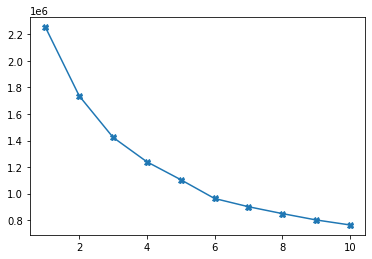

In [32]:
inertia = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_mkt)
    inertia.append((i,kmeans.inertia_,))

plt.plot([w[0] for w in inertia],[w[1] for w in inertia], marker="X")

Percebemos que existe um ganho significativo até o valor de 6 clusters, após isso o ganho passa a ser menor (método do cotovelo ou elbow method). Escolhidos então 6 clusters para trabalhar os dados. 

### Portfólio 1

In [33]:
df_mkt_cluster = df_mkt.copy()
# gera o modelo de KMeans
kmeans = KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10,
       n_clusters=6, n_init=30, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

# treina o modelo
kmeans.fit(df_port1)

#salva os clusters definidos pelo Kmeans de cada emrpesa do portfólio
clusters_port1 = kmeans.labels_

#salva as distancias para os clusters dos dados do portfólio
distancia_port1 = kmeans.transform(df_port1)
distancia_port1 = pd.DataFrame(distancia_port1)

#Salva adiciona nos dados do mercado os clusters previstos
clusters_mkt =  kmeans.predict(df_mkt)
df_mkt_cluster['cluster'] = clusters_mkt

#salva as distancias para os clusters dos dados do mercado
distancia_mkt = kmeans.transform(df_mkt)
distancia_mkt = pd.DataFrame(distancia_mkt)

#salvar lista das distancias de cada cluster dos dados do portfólio
dist_port1_cluster0 = (distancia_port1[0][clusters_port1 == 0]).to_list()
dist_port1_cluster1 = (distancia_port1[1][clusters_port1 == 1]).to_list()
dist_port1_cluster2 = (distancia_port1[2][clusters_port1 == 2]).to_list()
dist_port1_cluster3 = (distancia_port1[3][clusters_port1 == 3]).to_list()
dist_port1_cluster4 = (distancia_port1[4][clusters_port1 == 4]).to_list()
dist_port1_cluster5 = (distancia_port1[5][clusters_port1 == 5]).to_list()

#com base na distribuição de distancias de cada cluster, pegar um limite máximo aceitavel para prever no mercado mais a frente
if dist_port1_cluster0:
  limite_max_cluster0 = np.quantile(dist_port1_cluster0, 0.95)

if dist_port1_cluster1:
  limite_max_cluster1 = np.quantile(dist_port1_cluster1, 0.95)

if dist_port1_cluster2:
  limite_max_cluster2 = np.quantile(dist_port1_cluster2, 0.95)

if dist_port1_cluster3:
  limite_max_cluster3 = np.quantile(dist_port1_cluster3, 0.95)

if dist_port1_cluster4:
  limite_max_cluster4 = np.quantile(dist_port1_cluster4, 0.95)

if dist_port1_cluster5:
  limite_max_cluster5 = np.quantile(dist_port1_cluster5, 0.95)

df_mkt_cluster.insert(10, 'predito', False)

# Para cada Cluster:
# pegar dados mercado.
# pegaras distancias previstas desses dados. 
# definir um tataset de predicoes com as emrpesas que tenham distancia dentro so limite estabelecido para o cluster
# se estiver dentro do limite, setar coluna "predito" no data set principal para TRUE

mkt_cluster0       = (df_mkt_cluster[:][clusters_mkt == 0])
dist_mkt_cluster0  = np.array(distancia_mkt[0][clusters_mkt == 0])
preditos_cluster0 = mkt_cluster0[:][dist_mkt_cluster0 <= limite_max_cluster0]
df_mkt_cluster['predito'][df_mkt_cluster.index.isin(preditos_cluster0.index)] = True

mkt_cluster1       = (df_mkt_cluster[:][clusters_mkt == 1])
dist_mkt_cluster1  = np.array(distancia_mkt[1][clusters_mkt == 1])
preditos_cluster1 = mkt_cluster1[:][dist_mkt_cluster1 <= limite_max_cluster1]
df_mkt_cluster['predito'][df_mkt_cluster.index.isin(preditos_cluster1.index)] = True

mkt_cluster2       = (df_mkt_cluster[:][clusters_mkt == 2])
dist_mkt_cluster2  = np.array(distancia_mkt[2][clusters_mkt == 2])
preditos_cluster2 = mkt_cluster2[:][dist_mkt_cluster2 <= limite_max_cluster2]
df_mkt_cluster['predito'][df_mkt_cluster.index.isin(preditos_cluster2.index)] = True

mkt_cluster3       = (df_mkt_cluster[:][clusters_mkt == 3])
dist_mkt_cluster3  = np.array(distancia_mkt[3][clusters_mkt == 3])
preditos_cluster3 = mkt_cluster3[:][dist_mkt_cluster3 <= limite_max_cluster3]
df_mkt_cluster['predito'][df_mkt_cluster.index.isin(preditos_cluster3.index)] = True

mkt_cluster4       = (df_mkt_cluster[:][clusters_mkt == 4])
dist_mkt_cluster4  = np.array(distancia_mkt[4][clusters_mkt == 4])
preditos_cluster4 = mkt_cluster4[:][dist_mkt_cluster4 <= limite_max_cluster4]
df_mkt_cluster['predito'][df_mkt_cluster.index.isin(preditos_cluster4.index)] = True

mkt_cluster5       = (df_mkt_cluster[:][clusters_mkt == 5])
dist_mkt_cluster5  = np.array(distancia_mkt[5][clusters_mkt == 5])
preditos_cluster5 = mkt_cluster5[:][dist_mkt_cluster5 <= limite_max_cluster5]
df_mkt_cluster['predito'][df_mkt_cluster.index.isin(preditos_cluster5.index)] = True

cli_atual = df_mkt_cluster.index.isin(pt1.id) 

df_result = df_mkt_cluster.copy()

df_result.insert(11, 'already_client', cli_atual)

df_leads_pt1_kmeans = df_result.loc[(df_result['predito']==True) & (df_result['already_client']==False)]

#mensurando acertos com os leads esperados, que eu já sei que são meus, ou seja, já são meus clientes 
#observar que defini similaridade com 95% por isso não são retornados o total original deste portfólio
df_leads_esperados = df_result.loc[(df_result['predito']==True) & (df_result['already_client']==True)]

precisao_acertos = len(df_leads_esperados.index) / len(df_port1.index)

print(precisao_acertos)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to b

0.9459459459459459


In [34]:
df_leads_pt1_kmeans.to_csv('/gdrive/My Drive/CodenationRecommender/src/df_leads_pt1_kmeans.csv')

df_leads_pt1_kmeans

,fl_matriz,de_natureza_juridica,sg_uf,de_ramo,idade_emp_cat,fl_rm,de_saude_tributaria,de_nivel_atividade,de_faixa_faturamento_estimado,vl_faturamento_estimado_aux,predito,already_client,cluster
id,,,,,,,,,,,,,
a6984c3ae395090e3bee8ad63c3758b110de096d5d819583a784a113726db849,0.693147,4.110874,1.609438,2.484907,0.693147,0.693147,1.609438,0.000000,1.098612,14.957238,True,False,0
6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c47fdef50b33f4f56f05,0.693147,2.890372,1.386294,3.091042,0.000000,0.693147,1.098612,0.693147,2.397895,12.254868,True,False,5
0114fd3fbdc347c561843cde6aece12e8e53cb5d32c77dd2d5cb382605b7be79,0.693147,2.890372,1.609438,3.044522,1.609438,0.693147,1.609438,0.000000,2.397895,13.594979,True,False,0
6c45aabb849a760a3a7107c7a61262642f683feb8912a41a859f69fe4ce02b1c,0.693147,2.564949,0.693147,1.098612,0.693147,0.000000,0.693147,0.000000,2.397895,12.254868,True,False,5
2fcd678d71b04ccb77644fff57706bdc7fcfbbec6b19267e6600f46121b726e8,0.000000,2.890372,1.609438,1.791759,1.098612,0.000000,1.791759,1.098612,2.397895,12.254868,True,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5d8a8ef6c379dad93e2b719f9a852b52adda2bf1a0a55b85cd6376746eef3719,0.693147,2.890372,0.693147,1.791759,1.386294,0.000000,0.000000,1.098612,2.397895,12.254868,True,False,2
5e03ec1a510c0168eb98b81da2b0d12d5e85e1e5c6639a3cae6dc30f7160cbdc,0.693147,2.890372,1.386294,2.564949,0.000000,0.693147,1.609438,1.098612,0.693147,10.819798,True,False,3
c7d29b8f06b400d2664e93327d7c3379e25b0b04045e652edefa5ff60a1b25a8,0.693147,2.890372,1.386294,3.091042,0.000000,0.693147,1.098612,0.693147,2.397895,12.254868,True,False,5


### Portfólio 2

In [35]:
df_mkt_cluster = df_mkt.copy()
# gera o modelo de KMeans
kmeans = KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10,
       n_clusters=6, n_init=30, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

# treina o modelo
kmeans.fit(df_port2)

#salva os clusters definidos pelo Kmeans de cada emrpesa do portfólio
clusters_port2 = kmeans.labels_

#salva as distancias para os clusters dos dados do portfólio
distancia_port2 = kmeans.transform(df_port2)
distancia_port2 = pd.DataFrame(distancia_port2)

#salva e adiciona nos dados do mercado os clusters previstos
clusters_mkt =  kmeans.predict(df_mkt)
df_mkt_cluster['cluster'] = clusters_mkt

#salva as distancias para os clusters dos dados do mercado
distancia_mkt = kmeans.transform(df_mkt)
distancia_mkt = pd.DataFrame(distancia_mkt)

#salvar lista das distancias de cada cluster dos dados do portfólio
dist_port2_cluster0 = (distancia_port2[0][clusters_port2 == 0]).to_list()
dist_port2_cluster1 = (distancia_port2[1][clusters_port2 == 1]).to_list()
dist_port2_cluster2 = (distancia_port2[2][clusters_port2 == 2]).to_list()
dist_port2_cluster3 = (distancia_port2[3][clusters_port2 == 3]).to_list()
dist_port2_cluster4 = (distancia_port2[4][clusters_port2 == 4]).to_list()
dist_port2_cluster5 = (distancia_port2[5][clusters_port2 == 5]).to_list()

#com base na distribuição de distancias de cada cluster, pegar um limite máximo aceitavel para prever no mercado mais a frente
if dist_port2_cluster0:
  limite_max_cluster0 = np.quantile(dist_port2_cluster0, 0.95)

if dist_port2_cluster1:
  limite_max_cluster1 = np.quantile(dist_port2_cluster1, 0.95)

if dist_port2_cluster2:
  limite_max_cluster2 = np.quantile(dist_port2_cluster2, 0.95)

if dist_port2_cluster3:
  limite_max_cluster3 = np.quantile(dist_port2_cluster3, 0.95)

if dist_port2_cluster4:
  limite_max_cluster4 = np.quantile(dist_port2_cluster4, 0.95)

if dist_port2_cluster5:
  limite_max_cluster5 = np.quantile(dist_port2_cluster5, 0.95)

df_mkt_cluster.insert(10, 'predito', False)

# Para cada Cluster:
# pegar dados mercado.
# pegaras distancias previstas desses dados. 
# definir um tataset de predicoes com as emrpesas que tenham distancia dentro so limite estabelecido para o cluster
# se estiver dentro do limite, setar coluna "predito" no data set principal para TRUE

mkt_cluster0       = (df_mkt_cluster[:][clusters_mkt == 0])
dist_mkt_cluster0  = np.array(distancia_mkt[0][clusters_mkt == 0])
preditos_cluster0 = mkt_cluster0[:][dist_mkt_cluster0 <= limite_max_cluster0]
df_mkt_cluster['predito'][df_mkt_cluster.index.isin(preditos_cluster0.index)] = True

mkt_cluster1       = (df_mkt_cluster[:][clusters_mkt == 1])
dist_mkt_cluster1  = np.array(distancia_mkt[1][clusters_mkt == 1])
preditos_cluster1 = mkt_cluster1[:][dist_mkt_cluster1 <= limite_max_cluster1]
df_mkt_cluster['predito'][df_mkt_cluster.index.isin(preditos_cluster1.index)] = True

mkt_cluster2       = (df_mkt_cluster[:][clusters_mkt == 2])
dist_mkt_cluster2  = np.array(distancia_mkt[2][clusters_mkt == 2])
preditos_cluster2 = mkt_cluster2[:][dist_mkt_cluster2 <= limite_max_cluster2]
df_mkt_cluster['predito'][df_mkt_cluster.index.isin(preditos_cluster2.index)] = True

mkt_cluster3       = (df_mkt_cluster[:][clusters_mkt == 3])
dist_mkt_cluster3  = np.array(distancia_mkt[3][clusters_mkt == 3])
preditos_cluster3 = mkt_cluster3[:][dist_mkt_cluster3 <= limite_max_cluster3]
df_mkt_cluster['predito'][df_mkt_cluster.index.isin(preditos_cluster3.index)] = True

mkt_cluster4       = (df_mkt_cluster[:][clusters_mkt == 4])
dist_mkt_cluster4  = np.array(distancia_mkt[4][clusters_mkt == 4])
preditos_cluster4 = mkt_cluster4[:][dist_mkt_cluster4 <= limite_max_cluster4]
df_mkt_cluster['predito'][df_mkt_cluster.index.isin(preditos_cluster4.index)] = True

mkt_cluster5       = (df_mkt_cluster[:][clusters_mkt == 5])
dist_mkt_cluster5  = np.array(distancia_mkt[5][clusters_mkt == 5])
preditos_cluster5 = mkt_cluster5[:][dist_mkt_cluster5 <= limite_max_cluster5]
df_mkt_cluster['predito'][df_mkt_cluster.index.isin(preditos_cluster5.index)] = True
        

cli_atual = df_mkt_cluster.index.isin(pt2.id) 

df_result = df_mkt_cluster.copy()

df_result.insert(11, 'already_client', cli_atual)

df_leads_pt2_kmeans = df_result.loc[(df_result['predito']==True) & (df_result['already_client']==False)]

#mensurando acertos com os leads esperados, que eu já sei que são meus, ou seja, já são meus clientes 
#observar que defini similaridade com 95% por isso não são retornados o total original deste portfólio
df_leads_esperados = df_result.loc[(df_result['predito']==True) & (df_result['already_client']==True)]

precisao_acertos = len(df_leads_esperados.index) / len(df_port2.index)

print(precisao_acertos)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to b

0.9452296819787986


In [36]:
df_leads_pt2_kmeans.to_csv('/gdrive/My Drive/CodenationRecommender/src/df_leads_pt2_kmeans.csv')

df_leads_pt2_kmeans

,fl_matriz,de_natureza_juridica,sg_uf,de_ramo,idade_emp_cat,fl_rm,de_saude_tributaria,de_nivel_atividade,de_faixa_faturamento_estimado,vl_faturamento_estimado_aux,predito,already_client,cluster
id,,,,,,,,,,,,,
8a584390e7b2fba5ef33a51b2f8fd63bd202194db3e5eeecba6bd5beaac9c698,0.000000,4.025352,0.000000,3.295837,1.386294,0.000000,1.609438,0.0,1.386294,16.566675,True,False,0
6e292487550f4b68a5a710b1512039761b07cdb9d1125728af3e601076c8946b,0.693147,3.526361,1.386294,0.000000,1.791759,0.000000,0.693147,0.0,1.386294,17.212676,True,False,4
259b5218074df2fcdef54d97cd119654c97f10942c0d87368bf749ed08ff4819,0.693147,4.110874,0.693147,3.091042,1.791759,0.693147,1.609438,0.0,1.098612,15.251477,True,False,0
1f122f16a4182b7474c29e5c49d6598ee10b86d2ab115f6f9d5b8b9ecb8cc102,0.000000,4.110874,0.693147,1.791759,1.098612,0.693147,1.609438,0.0,1.386294,17.177585,True,False,1
a69961fa35f49e63f74cecf303437758b72a833371eea308b71948573d579110,0.000000,4.110874,1.098612,1.609438,1.098612,0.693147,1.609438,0.0,1.386294,17.068248,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
a66a105fce4de4bea9520f6507d1d5e1449bf577bee03d59c523a1400350c6af,0.000000,4.007333,1.098612,3.258097,1.791759,0.693147,1.609438,0.0,2.197225,15.841440,True,False,0
849315388f64eb2c10c27dc77cddce4229fff734feb26aeeec2566b32a2417cc,0.000000,4.110874,1.098612,1.098612,1.609438,0.693147,1.098612,0.0,1.386294,17.065255,True,False,1
7e36ab788c5bf3557ae03b50a5f0ba2bd0ae0cc70e600c72e3a5a8c685bed895,0.693147,4.110874,0.693147,1.791759,1.386294,0.693147,1.609438,0.0,2.197225,15.922319,True,False,1


### Portfólio 3

In [37]:
df_mkt_cluster = df_mkt.copy()
# gera o modelo de KMeans
kmeans = KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10,
       n_clusters=6, n_init=30, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

# treina o modelo
kmeans.fit(df_port3)

#salva os clusters definidos pelo Kmeans de cada emrpesa do portfólio
clusters_port3 = kmeans.labels_

#salva as distancias para os clusters dos dados do portfólio
distancia_port3 = kmeans.transform(df_port3)
distancia_port3 = pd.DataFrame(distancia_port3)

#adiciona nos dados do mercado os clusters previstos
df_mkt_cluster['cluster'] = kmeans.predict(df_mkt)

#Salva adiciona nos dados do mercado os clusters previstos
clusters_mkt =  kmeans.predict(df_mkt)
df_mkt_cluster['cluster'] = clusters_mkt

#salvar lista das distancias de cada cluster dos dados do portfólio
dist_port3_cluster0 = (distancia_port3[0][clusters_port3 == 0]).to_list()
dist_port3_cluster1 = (distancia_port3[1][clusters_port3 == 1]).to_list()
dist_port3_cluster2 = (distancia_port3[2][clusters_port3 == 2]).to_list()
dist_port3_cluster3 = (distancia_port3[3][clusters_port3 == 3]).to_list()
dist_port3_cluster4 = (distancia_port3[4][clusters_port3 == 4]).to_list()
dist_port3_cluster5 = (distancia_port3[5][clusters_port3 == 5]).to_list()

#com base na distribuição de distancias de cada cluster, pegar um limite máximo aceitavel para prever no mercado mais a frente
if dist_port3_cluster0:
  limite_max_cluster0 = np.quantile(dist_port3_cluster0, 0.95)

if dist_port3_cluster1:
  limite_max_cluster1 = np.quantile(dist_port3_cluster1, 0.95)

if dist_port3_cluster2:
  limite_max_cluster2 = np.quantile(dist_port3_cluster2, 0.95)

if dist_port3_cluster3:
  limite_max_cluster3 = np.quantile(dist_port3_cluster3, 0.95)

if dist_port3_cluster4:
  limite_max_cluster4 = np.quantile(dist_port3_cluster4, 0.95)

if dist_port3_cluster5:
  limite_max_cluster5 = np.quantile(dist_port3_cluster5, 0.95)

df_mkt_cluster.insert(10, 'predito', False)

# Para cada Cluster:
# pegar dados mercado.
# pegaras distancias previstas desses dados. 
# definir um tataset de predicoes com as emrpesas que tenham distancia dentro so limite estabelecido para o cluster
# se estiver dentro do limite, setar coluna "predito" no data set principal para TRUE

mkt_cluster0       = (df_mkt_cluster[:][clusters_mkt == 0])
dist_mkt_cluster0  = np.array(distancia_mkt[0][clusters_mkt == 0])
preditos_cluster0 = mkt_cluster0[:][dist_mkt_cluster0 <= limite_max_cluster0]
df_mkt_cluster['predito'][df_mkt_cluster.index.isin(preditos_cluster0.index)] = True

mkt_cluster1       = (df_mkt_cluster[:][clusters_mkt == 1])
dist_mkt_cluster1  = np.array(distancia_mkt[1][clusters_mkt == 1])
preditos_cluster1 = mkt_cluster1[:][dist_mkt_cluster1 <= limite_max_cluster1]
df_mkt_cluster['predito'][df_mkt_cluster.index.isin(preditos_cluster1.index)] = True

mkt_cluster2       = (df_mkt_cluster[:][clusters_mkt == 2])
dist_mkt_cluster2  = np.array(distancia_mkt[2][clusters_mkt == 2])
preditos_cluster2 = mkt_cluster2[:][dist_mkt_cluster2 <= limite_max_cluster2]
df_mkt_cluster['predito'][df_mkt_cluster.index.isin(preditos_cluster2.index)] = True

mkt_cluster3       = (df_mkt_cluster[:][clusters_mkt == 3])
dist_mkt_cluster3  = np.array(distancia_mkt[3][clusters_mkt == 3])
preditos_cluster3 = mkt_cluster3[:][dist_mkt_cluster3 <= limite_max_cluster3]
df_mkt_cluster['predito'][df_mkt_cluster.index.isin(preditos_cluster3.index)] = True

mkt_cluster4       = (df_mkt_cluster[:][clusters_mkt == 4])
dist_mkt_cluster4  = np.array(distancia_mkt[4][clusters_mkt == 4])
preditos_cluster4 = mkt_cluster4[:][dist_mkt_cluster4 <= limite_max_cluster4]
df_mkt_cluster['predito'][df_mkt_cluster.index.isin(preditos_cluster4.index)] = True

mkt_cluster5       = (df_mkt_cluster[:][clusters_mkt == 5])
dist_mkt_cluster5  = np.array(distancia_mkt[5][clusters_mkt == 5])
preditos_cluster5 = mkt_cluster5[:][dist_mkt_cluster5 <= limite_max_cluster5]
df_mkt_cluster['predito'][df_mkt_cluster.index.isin(preditos_cluster5.index)] = True
        

cli_atual = df_mkt_cluster.index.isin(pt3.id) 

df_result = df_mkt_cluster.copy()

df_result.insert(11, 'already_client', cli_atual)

df_leads_pt3_kmeans = df_result.loc[(df_result['predito']==True) & (df_result['already_client']==False)]

#mensurando acertos com os leads esperados, que eu já sei que são meus, ou seja, já são meus clientes 
#observar que defini similaridade com 95% por isso não são retornados o total original deste portfólio
df_leads_esperados = df_result.loc[(df_result['predito']==True) & (df_result['already_client']==True)]

precisao_acertos = len(df_leads_esperados.index) / len(df_port3.index)

print(precisao_acertos)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to b

0.28679245283018867


In [38]:
df_leads_pt3_kmeans.to_csv('/gdrive/My Drive/CodenationRecommender/src/df_leads_pt3_kmeans.csv')

df_leads_pt3_kmeans

,fl_matriz,de_natureza_juridica,sg_uf,de_ramo,idade_emp_cat,fl_rm,de_saude_tributaria,de_nivel_atividade,de_faixa_faturamento_estimado,vl_faturamento_estimado_aux,predito,already_client,cluster
id,,,,,,,,,,,,,
8a584390e7b2fba5ef33a51b2f8fd63bd202194db3e5eeecba6bd5beaac9c698,0.000000,4.025352,0.000000,3.295837,1.386294,0.000000,1.609438,0.0,1.386294,16.566675,True,False,0
259b5218074df2fcdef54d97cd119654c97f10942c0d87368bf749ed08ff4819,0.693147,4.110874,0.693147,3.091042,1.791759,0.693147,1.609438,0.0,1.098612,15.251477,True,False,0
1f122f16a4182b7474c29e5c49d6598ee10b86d2ab115f6f9d5b8b9ecb8cc102,0.000000,4.110874,0.693147,1.791759,1.098612,0.693147,1.609438,0.0,1.386294,17.177585,True,False,0
a69961fa35f49e63f74cecf303437758b72a833371eea308b71948573d579110,0.000000,4.110874,1.098612,1.609438,1.098612,0.693147,1.609438,0.0,1.386294,17.068248,True,False,0
59d43a34290fd77e9b35e6eb5374ca7bd3ef67a2e1c50720faa4478002d00ad1,0.693147,4.110874,1.386294,2.197225,0.693147,0.693147,1.609438,0.0,1.386294,17.033590,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
a66a105fce4de4bea9520f6507d1d5e1449bf577bee03d59c523a1400350c6af,0.000000,4.007333,1.098612,3.258097,1.791759,0.693147,1.609438,0.0,2.197225,15.841440,True,False,0
849315388f64eb2c10c27dc77cddce4229fff734feb26aeeec2566b32a2417cc,0.000000,4.110874,1.098612,1.098612,1.609438,0.693147,1.098612,0.0,1.386294,17.065255,True,False,1
8a226339b331b5aec24877a69edc40070b9dd7e71b21943996db577948efaf69,0.693147,4.110874,1.386294,2.484907,1.791759,0.693147,1.609438,0.0,1.386294,16.800290,True,False,0


## Conclusão

Diante dos testes realizados, o método KMEANs além de mais perfomático, se mostrou muito mais sensível ao selecionar os leads em comparação com o modelo OneClassSVM, e por isso foi o modelo adotado.

In [39]:
resposta_port1 = pd.read_csv('/gdrive/My Drive/CodenationRecommender/src/df_leads_pt1_kmeans.csv')
resposta_port2 = pd.read_csv('/gdrive/My Drive/CodenationRecommender/src/df_leads_pt2_kmeans.csv')
resposta_port3 = pd.read_csv('/gdrive/My Drive/CodenationRecommender/src/df_leads_pt3_kmeans.csv')

resposta_port1 = resposta_port1['id']
resposta_port2 = resposta_port2['id']
resposta_port3 = resposta_port3['id']

resposta_port1.to_csv('/gdrive/My Drive/CodenationRecommender/src/resposta_port1.csv')
resposta_port2.to_csv('/gdrive/My Drive/CodenationRecommender/src/resposta_port2.csv')
resposta_port3.to_csv('/gdrive/My Drive/CodenationRecommender/src/resposta_port3.csv')

# **Gráficos Comparativos: portfólios x Previsões x Mercado**

## Portfólio 1

No handles with labels found to put in legend.


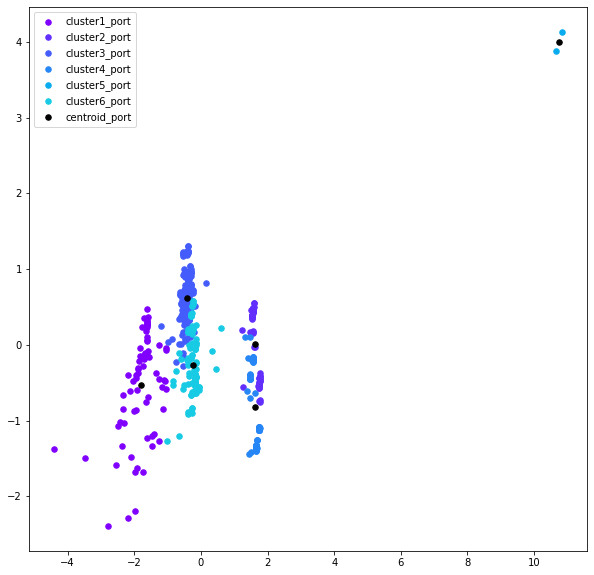

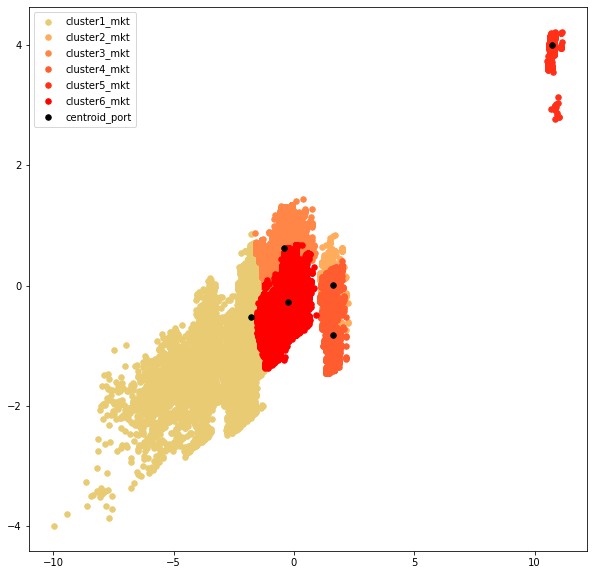

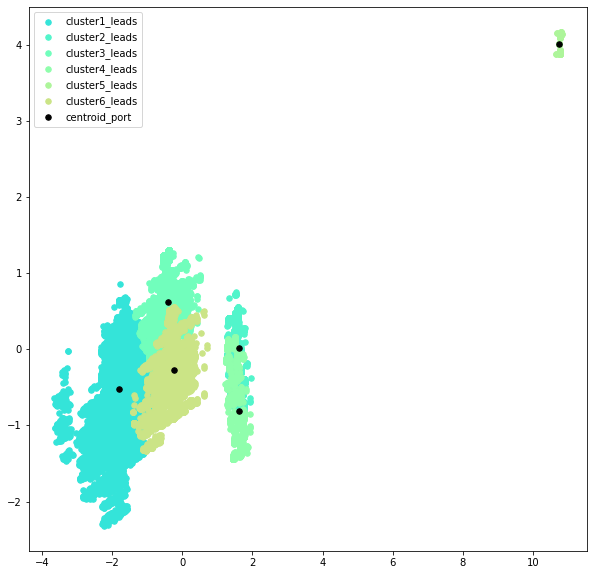

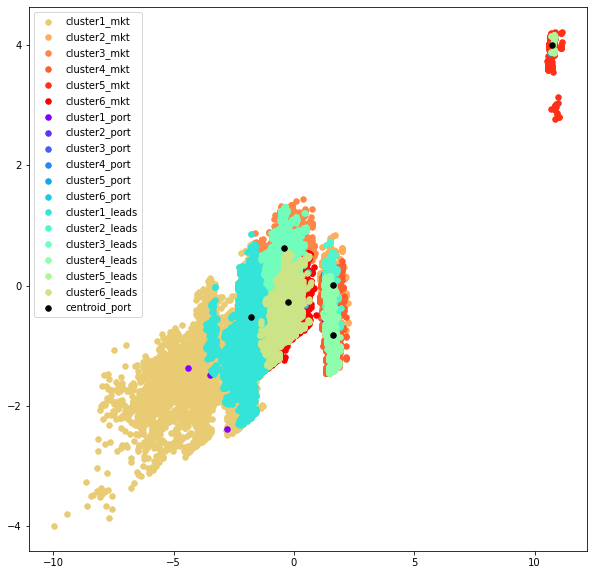

In [40]:
#carrega dados de portfólio, leads previstos e mercado
df_mkt = pd.read_csv('/gdrive/My Drive/CodenationRecommender/src/df_mkt_enc.csv', index_col = 0)
df_port1 = df_mkt[df_mkt.index.isin(pt1.id)]
leads_port1 = pd.read_csv('/gdrive/My Drive/CodenationRecommender/src/df_leads_pt1_kmeans.csv',  index_col = 0)

clusters_leads_port1 = leads_port1['cluster']

leads_port1 = df_mkt[df_mkt.index.isin(leads_port1.index)]

#aplicando kmeans no portfólio para gerar os clusters
kmeans = KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10,
       n_clusters=6, n_init=30, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)


kmeans.fit(df_port1)

#buscando clusters previstos para portfólio, leads previstos e mercado
mkt_predict = kmeans.predict(df_mkt)
df_port1_predict = kmeans.labels_
leads_port1_predict = clusters_leads_port1

#aplicando PCA para reduzir dimenções e utilizar PC1 e PC2 para visualizar os dados
pca = PCA(0.95)
pca.fit(df_port1)

#gerando lista de componentes do PCA para portfólio, leads previstos e mercado
new_mkt = pca.transform(df_mkt)
new_port1 = pca.transform(df_port1)
new_leads_port1 = pca.transform(leads_port1)
new_centroids = pca.transform(kmeans.cluster_centers_)

#definindo range de cores, tamanho do gráfico e posição da legenda
colors = cm.rainbow(np.linspace(0, 1, 18))
plt.rcParams['figure.figsize'] = (10,10)
plt.legend(loc='best')

#plotando infomações em gráficos separados

#Plotando empresas do portfólio
print(plt.scatter(new_port1[df_port1_predict == 0, 0], new_port1[df_port1_predict == 0, 1], s=30, color=colors[0], label='cluster1_port'))
print(plt.scatter(new_port1[df_port1_predict == 1, 0], new_port1[df_port1_predict == 1, 1], s=30, color=colors[1], label='cluster2_port'))
print(plt.scatter(new_port1[df_port1_predict == 2, 0], new_port1[df_port1_predict == 2, 1], s=30, color=colors[2], label='cluster3_port'))
print(plt.scatter(new_port1[df_port1_predict == 3, 0], new_port1[df_port1_predict == 3, 1], s=30, color=colors[3], label='cluster4_port'))
print(plt.scatter(new_port1[df_port1_predict == 4, 0], new_port1[df_port1_predict == 4, 1], s=30, color=colors[4], label='cluster5_port'))
print(plt.scatter(new_port1[df_port1_predict == 5, 0], new_port1[df_port1_predict == 5, 1], s=30, color=colors[5], label='cluster6_port'))

plt.scatter(new_centroids[:, 0], new_centroids[:, 1], s=30, color='black', label='centroid_port')
plt.legend()
plt.show()

#Plotando empresas do mercado
print(plt.scatter(new_mkt[mkt_predict == 0, 0], new_mkt[mkt_predict == 0, 1], s=30, color=colors[12], label='cluster1_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 1, 0], new_mkt[mkt_predict == 1, 1], s=30, color=colors[13], label='cluster2_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 2, 0], new_mkt[mkt_predict == 2, 1], s=30, color=colors[14], label='cluster3_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 3, 0], new_mkt[mkt_predict == 3, 1], s=30, color=colors[15], label='cluster4_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 4, 0], new_mkt[mkt_predict == 4, 1], s=30, color=colors[16], label='cluster5_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 5, 0], new_mkt[mkt_predict == 5, 1], s=30, color=colors[17], label='cluster6_mkt'))

plt.scatter(new_centroids[:, 0], new_centroids[:, 1], s=30, color='black', label='centroid_port')
plt.legend()
plt.show()

#Plotando empresas recomendadas
print(plt.scatter(new_leads_port1[leads_port1_predict == 0, 0], new_leads_port1[leads_port1_predict == 0, 1], s=30, color=colors[6], label='cluster1_leads'))
print(plt.scatter(new_leads_port1[leads_port1_predict == 1, 0], new_leads_port1[leads_port1_predict == 1, 1], s=30, color=colors[7], label='cluster2_leads'))
print(plt.scatter(new_leads_port1[leads_port1_predict == 2, 0], new_leads_port1[leads_port1_predict == 2, 1], s=30, color=colors[8], label='cluster3_leads'))
print(plt.scatter(new_leads_port1[leads_port1_predict == 3, 0], new_leads_port1[leads_port1_predict == 3, 1], s=30, color=colors[9], label='cluster4_leads'))
print(plt.scatter(new_leads_port1[leads_port1_predict == 4, 0], new_leads_port1[leads_port1_predict == 4, 1], s=30, color=colors[10], label='cluster5_leads'))
print(plt.scatter(new_leads_port1[leads_port1_predict == 5, 0], new_leads_port1[leads_port1_predict == 5, 1], s=30, color=colors[11], label='cluster6_leads'))

plt.scatter(new_centroids[:, 0], new_centroids[:, 1], s=30, color='black', label='centroid_port')
plt.legend()
plt.show()

#Plotando tudo em um mesmo gráfico

#Plotando empresas do mercado
print(plt.scatter(new_mkt[mkt_predict == 0, 0], new_mkt[mkt_predict == 0, 1], s=30, color=colors[12], label='cluster1_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 1, 0], new_mkt[mkt_predict == 1, 1], s=30, color=colors[13], label='cluster2_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 2, 0], new_mkt[mkt_predict == 2, 1], s=30, color=colors[14], label='cluster3_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 3, 0], new_mkt[mkt_predict == 3, 1], s=30, color=colors[15], label='cluster4_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 4, 0], new_mkt[mkt_predict == 4, 1], s=30, color=colors[16], label='cluster5_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 5, 0], new_mkt[mkt_predict == 5, 1], s=30, color=colors[17], label='cluster6_mkt'))

#Plotando empresas do portfólio
print(plt.scatter(new_port1[df_port1_predict == 0, 0], new_port1[df_port1_predict == 0, 1], s=30, color=colors[0], label='cluster1_port'))
print(plt.scatter(new_port1[df_port1_predict == 1, 0], new_port1[df_port1_predict == 1, 1], s=30, color=colors[1], label='cluster2_port'))
print(plt.scatter(new_port1[df_port1_predict == 2, 0], new_port1[df_port1_predict == 2, 1], s=30, color=colors[2], label='cluster3_port'))
print(plt.scatter(new_port1[df_port1_predict == 3, 0], new_port1[df_port1_predict == 3, 1], s=30, color=colors[3], label='cluster4_port'))
print(plt.scatter(new_port1[df_port1_predict == 4, 0], new_port1[df_port1_predict == 4, 1], s=30, color=colors[4], label='cluster5_port'))
print(plt.scatter(new_port1[df_port1_predict == 5, 0], new_port1[df_port1_predict == 5, 1], s=30, color=colors[5], label='cluster6_port'))

#Plotando empresas recomendadas
print(plt.scatter(new_leads_port1[leads_port1_predict == 0, 0], new_leads_port1[leads_port1_predict == 0, 1], s=30, color=colors[6], label='cluster1_leads'))
print(plt.scatter(new_leads_port1[leads_port1_predict == 1, 0], new_leads_port1[leads_port1_predict == 1, 1], s=30, color=colors[7], label='cluster2_leads'))
print(plt.scatter(new_leads_port1[leads_port1_predict == 2, 0], new_leads_port1[leads_port1_predict == 2, 1], s=30, color=colors[8], label='cluster3_leads'))
print(plt.scatter(new_leads_port1[leads_port1_predict == 3, 0], new_leads_port1[leads_port1_predict == 3, 1], s=30, color=colors[9], label='cluster4_leads'))
print(plt.scatter(new_leads_port1[leads_port1_predict == 4, 0], new_leads_port1[leads_port1_predict == 4, 1], s=30, color=colors[10], label='cluster5_leads'))
print(plt.scatter(new_leads_port1[leads_port1_predict == 5, 0], new_leads_port1[leads_port1_predict == 5, 1], s=30, color=colors[11], label='cluster6_leads'))

plt.scatter(new_centroids[:, 0], new_centroids[:, 1], s=30, color='black', label='centroid_port')
plt.legend()
plt.show()

## Portfólio 2

No handles with labels found to put in legend.


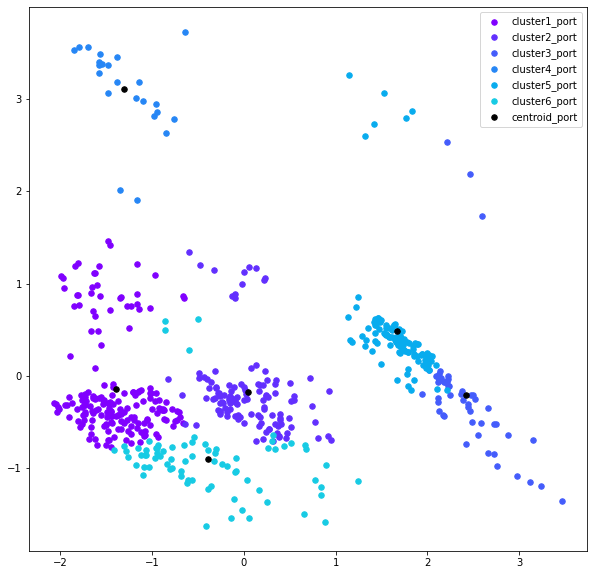

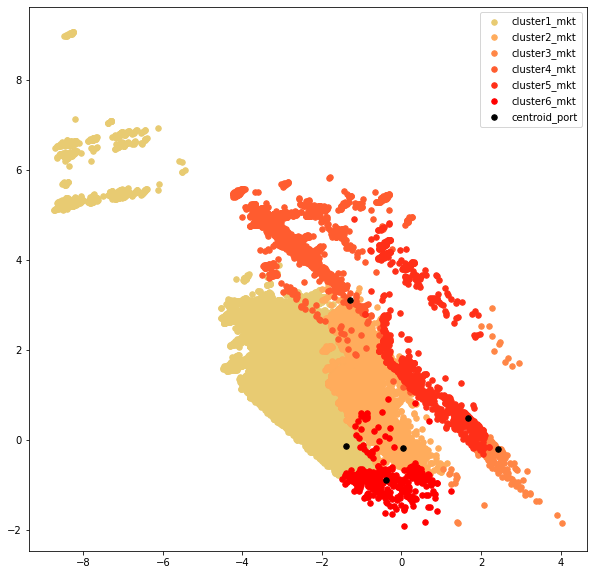

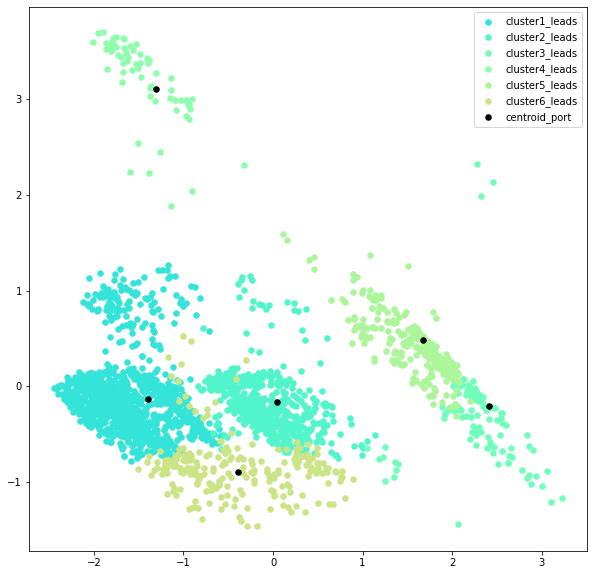

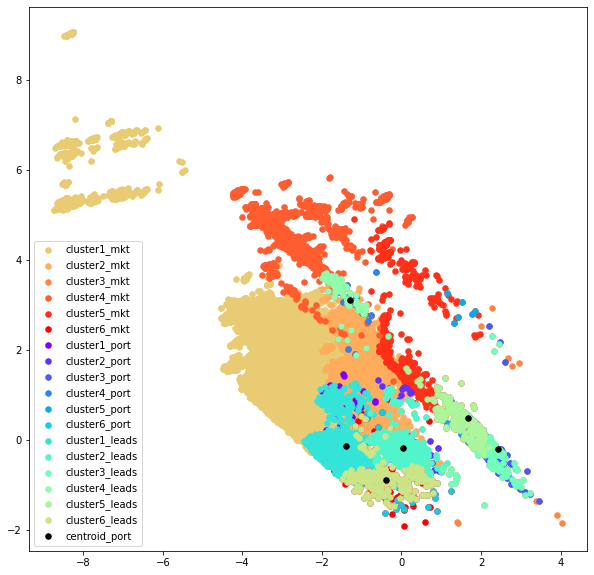

In [41]:
#carrega dados de portfólio, leads previstos e mercado
df_mkt = pd.read_csv('/gdrive/My Drive/CodenationRecommender/src/df_mkt_enc.csv', index_col = 0)
df_port2 = df_mkt[df_mkt.index.isin(pt2.id)]
leads_port2 = pd.read_csv('/gdrive/My Drive/CodenationRecommender/src/df_leads_pt2_kmeans.csv',  index_col = 0)

clusters_leads_port2 = leads_port2['cluster']

leads_port2 = df_mkt[df_mkt.index.isin(leads_port2.index)]

#aplicando kmeans no portfólio para gerar os clusters
kmeans = KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10,
       n_clusters=6, n_init=30, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)


kmeans.fit(df_port2)

#buscando clusters previstos para portfólio, leads previstos e mercado
mkt_predict = kmeans.predict(df_mkt)
df_port2_predict = kmeans.labels_
leads_port2_predict = clusters_leads_port2

#aplicando PCA para reduzir dimenções e utilizar PC1 e PC2 para visualizar os dados
pca = PCA(0.95)
pca.fit(df_port2)

#gerando lista de componentes do PCA para portfólio, leads previstos e mercado
new_mkt = pca.transform(df_mkt)
new_port2 = pca.transform(df_port2)
new_leads_port2 = pca.transform(leads_port2)
new_centroids = pca.transform(kmeans.cluster_centers_)

#definindo range de cores, tamanho do gráfico e posição da legenda
colors = cm.rainbow(np.linspace(0, 1, 18))
plt.rcParams['figure.figsize'] = (10,10)
plt.legend(loc='best')

#plotando infomações em gráficos separados

#Plotando empresas do portfólio
print(plt.scatter(new_port2[df_port2_predict == 0, 0], new_port2[df_port2_predict == 0, 1], s=30, color=colors[0], label='cluster1_port'))
print(plt.scatter(new_port2[df_port2_predict == 1, 0], new_port2[df_port2_predict == 1, 1], s=30, color=colors[1], label='cluster2_port'))
print(plt.scatter(new_port2[df_port2_predict == 2, 0], new_port2[df_port2_predict == 2, 1], s=30, color=colors[2], label='cluster3_port'))
print(plt.scatter(new_port2[df_port2_predict == 3, 0], new_port2[df_port2_predict == 3, 1], s=30, color=colors[3], label='cluster4_port'))
print(plt.scatter(new_port2[df_port2_predict == 4, 0], new_port2[df_port2_predict == 4, 1], s=30, color=colors[4], label='cluster5_port'))
print(plt.scatter(new_port2[df_port2_predict == 5, 0], new_port2[df_port2_predict == 5, 1], s=30, color=colors[5], label='cluster6_port'))

plt.scatter(new_centroids[:, 0], new_centroids[:, 1], s=30, color='black', label='centroid_port')
plt.legend()
plt.show()

#Plotando empresas do mercado
print(plt.scatter(new_mkt[mkt_predict == 0, 0], new_mkt[mkt_predict == 0, 1], s=30, color=colors[12], label='cluster1_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 1, 0], new_mkt[mkt_predict == 1, 1], s=30, color=colors[13], label='cluster2_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 2, 0], new_mkt[mkt_predict == 2, 1], s=30, color=colors[14], label='cluster3_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 3, 0], new_mkt[mkt_predict == 3, 1], s=30, color=colors[15], label='cluster4_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 4, 0], new_mkt[mkt_predict == 4, 1], s=30, color=colors[16], label='cluster5_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 5, 0], new_mkt[mkt_predict == 5, 1], s=30, color=colors[17], label='cluster6_mkt'))

plt.scatter(new_centroids[:, 0], new_centroids[:, 1], s=30, color='black', label='centroid_port')
plt.legend()
plt.show()

#Plotando empresas recomendadas
print(plt.scatter(new_leads_port2[leads_port2_predict == 0, 0], new_leads_port2[leads_port2_predict == 0, 1], s=30, color=colors[6], label='cluster1_leads'))
print(plt.scatter(new_leads_port2[leads_port2_predict == 1, 0], new_leads_port2[leads_port2_predict == 1, 1], s=30, color=colors[7], label='cluster2_leads'))
print(plt.scatter(new_leads_port2[leads_port2_predict == 2, 0], new_leads_port2[leads_port2_predict == 2, 1], s=30, color=colors[8], label='cluster3_leads'))
print(plt.scatter(new_leads_port2[leads_port2_predict == 3, 0], new_leads_port2[leads_port2_predict == 3, 1], s=30, color=colors[9], label='cluster4_leads'))
print(plt.scatter(new_leads_port2[leads_port2_predict == 4, 0], new_leads_port2[leads_port2_predict == 4, 1], s=30, color=colors[10], label='cluster5_leads'))
print(plt.scatter(new_leads_port2[leads_port2_predict == 5, 0], new_leads_port2[leads_port2_predict == 5, 1], s=30, color=colors[11], label='cluster6_leads'))

plt.scatter(new_centroids[:, 0], new_centroids[:, 1], s=30, color='black', label='centroid_port')
plt.legend()
plt.show()

#Plotando tudo em um mesmo gráfico

#Plotando empresas do mercado
print(plt.scatter(new_mkt[mkt_predict == 0, 0], new_mkt[mkt_predict == 0, 1], s=30, color=colors[12], label='cluster1_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 1, 0], new_mkt[mkt_predict == 1, 1], s=30, color=colors[13], label='cluster2_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 2, 0], new_mkt[mkt_predict == 2, 1], s=30, color=colors[14], label='cluster3_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 3, 0], new_mkt[mkt_predict == 3, 1], s=30, color=colors[15], label='cluster4_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 4, 0], new_mkt[mkt_predict == 4, 1], s=30, color=colors[16], label='cluster5_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 5, 0], new_mkt[mkt_predict == 5, 1], s=30, color=colors[17], label='cluster6_mkt'))

#Plotando empresas do portfólio
print(plt.scatter(new_port2[df_port2_predict == 0, 0], new_port2[df_port2_predict == 0, 1], s=30, color=colors[0], label='cluster1_port'))
print(plt.scatter(new_port2[df_port2_predict == 1, 0], new_port2[df_port2_predict == 1, 1], s=30, color=colors[1], label='cluster2_port'))
print(plt.scatter(new_port2[df_port2_predict == 2, 0], new_port2[df_port2_predict == 2, 1], s=30, color=colors[2], label='cluster3_port'))
print(plt.scatter(new_port2[df_port2_predict == 3, 0], new_port2[df_port2_predict == 3, 1], s=30, color=colors[3], label='cluster4_port'))
print(plt.scatter(new_port2[df_port2_predict == 4, 0], new_port2[df_port2_predict == 4, 1], s=30, color=colors[4], label='cluster5_port'))
print(plt.scatter(new_port2[df_port2_predict == 5, 0], new_port2[df_port2_predict == 5, 1], s=30, color=colors[5], label='cluster6_port'))

#Plotando empresas recomendadas
print(plt.scatter(new_leads_port2[leads_port2_predict == 0, 0], new_leads_port2[leads_port2_predict == 0, 1], s=30, color=colors[6], label='cluster1_leads'))
print(plt.scatter(new_leads_port2[leads_port2_predict == 1, 0], new_leads_port2[leads_port2_predict == 1, 1], s=30, color=colors[7], label='cluster2_leads'))
print(plt.scatter(new_leads_port2[leads_port2_predict == 2, 0], new_leads_port2[leads_port2_predict == 2, 1], s=30, color=colors[8], label='cluster3_leads'))
print(plt.scatter(new_leads_port2[leads_port2_predict == 3, 0], new_leads_port2[leads_port2_predict == 3, 1], s=30, color=colors[9], label='cluster4_leads'))
print(plt.scatter(new_leads_port2[leads_port2_predict == 4, 0], new_leads_port2[leads_port2_predict == 4, 1], s=30, color=colors[10], label='cluster5_leads'))
print(plt.scatter(new_leads_port2[leads_port2_predict == 5, 0], new_leads_port2[leads_port2_predict == 5, 1], s=30, color=colors[11], label='cluster6_leads'))

plt.scatter(new_centroids[:, 0], new_centroids[:, 1], s=30, color='black', label='centroid_port')
plt.legend()
plt.show()

## Portfólio 3

No handles with labels found to put in legend.


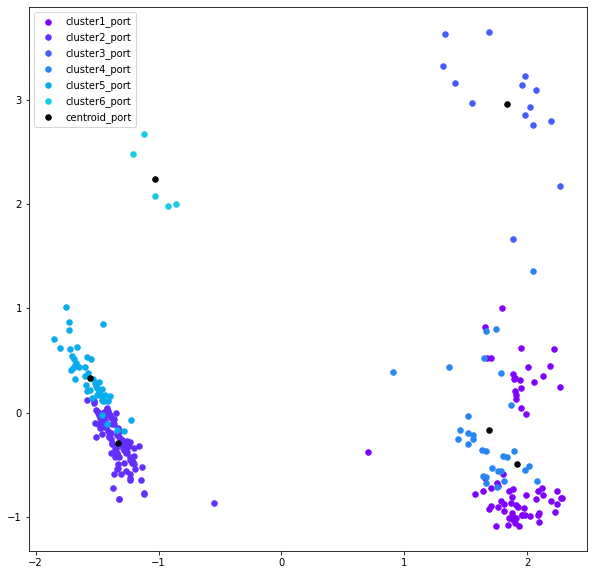

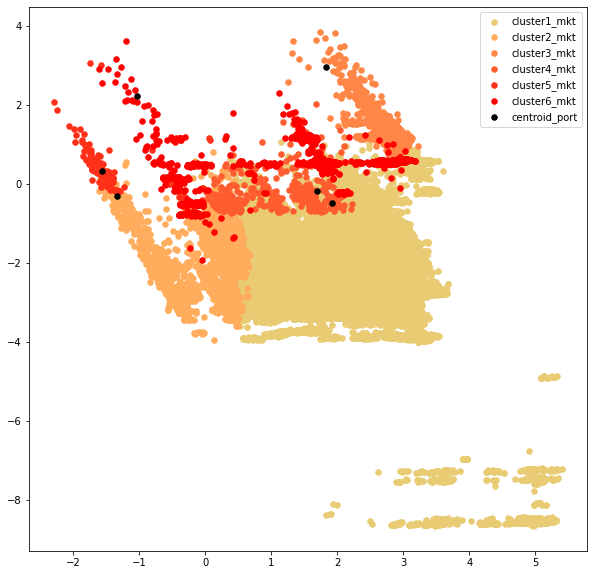

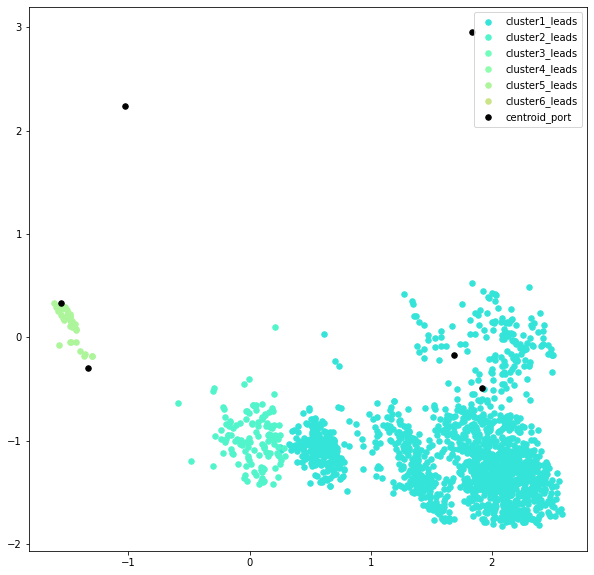

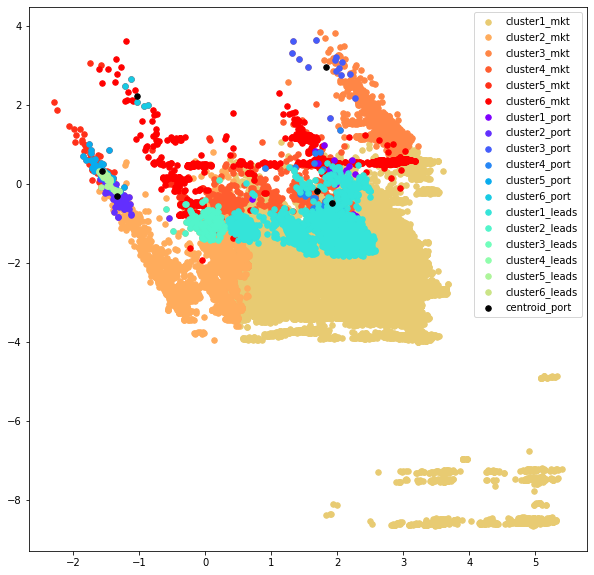

In [42]:
#carrega dados de portfólio, leads previstos e mercado
df_mkt = pd.read_csv('/gdrive/My Drive/CodenationRecommender/src/df_mkt_enc.csv', index_col = 0)
df_port3 = df_mkt[df_mkt.index.isin(pt3.id)]
leads_port3 = pd.read_csv('/gdrive/My Drive/CodenationRecommender/src/df_leads_pt3_kmeans.csv',  index_col = 0)

clusters_leads_port3 = leads_port3['cluster']

leads_port3 = df_mkt[df_mkt.index.isin(leads_port3.index)]

#aplicando kmeans no portfólio para gerar os clusters
kmeans = KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10,
       n_clusters=6, n_init=30, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)


kmeans.fit(df_port3)

#buscando clusters previstos para portfólio, leads previstos e mercado
mkt_predict = kmeans.predict(df_mkt)
df_port3_predict = kmeans.labels_
leads_port3_predict = clusters_leads_port3

#aplicando PCA para reduzir dimenções e utilizar PC1 e PC2 para visualizar os dados
pca = PCA(0.95)
pca.fit(df_port3)

#gerando lista de componentes do PCA para portfólio, leads previstos e mercado
new_mkt = pca.transform(df_mkt)
new_port3 = pca.transform(df_port3)
new_leads_port3 = pca.transform(leads_port3)
new_centroids = pca.transform(kmeans.cluster_centers_)

#definindo range de cores, tamanho do gráfico e posição da legenda
colors = cm.rainbow(np.linspace(0, 1, 18))
plt.rcParams['figure.figsize'] = (10,10)
plt.legend(loc='best')

#plotando infomações em gráficos separados

#Plotando empresas do portfólio
print(plt.scatter(new_port3[df_port3_predict == 0, 0], new_port3[df_port3_predict == 0, 1], s=30, color=colors[0], label='cluster1_port'))
print(plt.scatter(new_port3[df_port3_predict == 1, 0], new_port3[df_port3_predict == 1, 1], s=30, color=colors[1], label='cluster2_port'))
print(plt.scatter(new_port3[df_port3_predict == 2, 0], new_port3[df_port3_predict == 2, 1], s=30, color=colors[2], label='cluster3_port'))
print(plt.scatter(new_port3[df_port3_predict == 3, 0], new_port3[df_port3_predict == 3, 1], s=30, color=colors[3], label='cluster4_port'))
print(plt.scatter(new_port3[df_port3_predict == 4, 0], new_port3[df_port3_predict == 4, 1], s=30, color=colors[4], label='cluster5_port'))
print(plt.scatter(new_port3[df_port3_predict == 5, 0], new_port3[df_port3_predict == 5, 1], s=30, color=colors[5], label='cluster6_port'))

plt.scatter(new_centroids[:, 0], new_centroids[:, 1], s=30, color='black', label='centroid_port')
plt.legend()
plt.show()

#Plotando empresas do mercado
print(plt.scatter(new_mkt[mkt_predict == 0, 0], new_mkt[mkt_predict == 0, 1], s=30, color=colors[12], label='cluster1_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 1, 0], new_mkt[mkt_predict == 1, 1], s=30, color=colors[13], label='cluster2_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 2, 0], new_mkt[mkt_predict == 2, 1], s=30, color=colors[14], label='cluster3_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 3, 0], new_mkt[mkt_predict == 3, 1], s=30, color=colors[15], label='cluster4_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 4, 0], new_mkt[mkt_predict == 4, 1], s=30, color=colors[16], label='cluster5_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 5, 0], new_mkt[mkt_predict == 5, 1], s=30, color=colors[17], label='cluster6_mkt'))

plt.scatter(new_centroids[:, 0], new_centroids[:, 1], s=30, color='black', label='centroid_port')
plt.legend()
plt.show()

#Plotando empresas recomendadas
print(plt.scatter(new_leads_port3[leads_port3_predict == 0, 0], new_leads_port3[leads_port3_predict == 0, 1], s=30, color=colors[6], label='cluster1_leads'))
print(plt.scatter(new_leads_port3[leads_port3_predict == 1, 0], new_leads_port3[leads_port3_predict == 1, 1], s=30, color=colors[7], label='cluster2_leads'))
print(plt.scatter(new_leads_port3[leads_port3_predict == 2, 0], new_leads_port3[leads_port3_predict == 2, 1], s=30, color=colors[8], label='cluster3_leads'))
print(plt.scatter(new_leads_port3[leads_port3_predict == 3, 0], new_leads_port3[leads_port3_predict == 3, 1], s=30, color=colors[9], label='cluster4_leads'))
print(plt.scatter(new_leads_port3[leads_port3_predict == 4, 0], new_leads_port3[leads_port3_predict == 4, 1], s=30, color=colors[10], label='cluster5_leads'))
print(plt.scatter(new_leads_port3[leads_port3_predict == 5, 0], new_leads_port3[leads_port3_predict == 5, 1], s=30, color=colors[11], label='cluster6_leads'))

plt.scatter(new_centroids[:, 0], new_centroids[:, 1], s=30, color='black', label='centroid_port')
plt.legend()
plt.show()

#Plotando tudo em um mesmo gráfico

#Plotando empresas do mercado
print(plt.scatter(new_mkt[mkt_predict == 0, 0], new_mkt[mkt_predict == 0, 1], s=30, color=colors[12], label='cluster1_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 1, 0], new_mkt[mkt_predict == 1, 1], s=30, color=colors[13], label='cluster2_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 2, 0], new_mkt[mkt_predict == 2, 1], s=30, color=colors[14], label='cluster3_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 3, 0], new_mkt[mkt_predict == 3, 1], s=30, color=colors[15], label='cluster4_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 4, 0], new_mkt[mkt_predict == 4, 1], s=30, color=colors[16], label='cluster5_mkt'))
print(plt.scatter(new_mkt[mkt_predict == 5, 0], new_mkt[mkt_predict == 5, 1], s=30, color=colors[17], label='cluster6_mkt'))

#Plotando empresas do portfólio
print(plt.scatter(new_port3[df_port3_predict == 0, 0], new_port3[df_port3_predict == 0, 1], s=30, color=colors[0], label='cluster1_port'))
print(plt.scatter(new_port3[df_port3_predict == 1, 0], new_port3[df_port3_predict == 1, 1], s=30, color=colors[1], label='cluster2_port'))
print(plt.scatter(new_port3[df_port3_predict == 2, 0], new_port3[df_port3_predict == 2, 1], s=30, color=colors[2], label='cluster3_port'))
print(plt.scatter(new_port3[df_port3_predict == 3, 0], new_port3[df_port3_predict == 3, 1], s=30, color=colors[3], label='cluster4_port'))
print(plt.scatter(new_port3[df_port3_predict == 4, 0], new_port3[df_port3_predict == 4, 1], s=30, color=colors[4], label='cluster5_port'))
print(plt.scatter(new_port3[df_port3_predict == 5, 0], new_port3[df_port3_predict == 5, 1], s=30, color=colors[5], label='cluster6_port'))

#Plotando empresas recomendadas
print(plt.scatter(new_leads_port3[leads_port3_predict == 0, 0], new_leads_port3[leads_port3_predict == 0, 1], s=30, color=colors[6], label='cluster1_leads'))
print(plt.scatter(new_leads_port3[leads_port3_predict == 1, 0], new_leads_port3[leads_port3_predict == 1, 1], s=30, color=colors[7], label='cluster2_leads'))
print(plt.scatter(new_leads_port3[leads_port3_predict == 2, 0], new_leads_port3[leads_port3_predict == 2, 1], s=30, color=colors[8], label='cluster3_leads'))
print(plt.scatter(new_leads_port3[leads_port3_predict == 3, 0], new_leads_port3[leads_port3_predict == 3, 1], s=30, color=colors[9], label='cluster4_leads'))
print(plt.scatter(new_leads_port3[leads_port3_predict == 4, 0], new_leads_port3[leads_port3_predict == 4, 1], s=30, color=colors[10], label='cluster5_leads'))
print(plt.scatter(new_leads_port3[leads_port3_predict == 5, 0], new_leads_port3[leads_port3_predict == 5, 1], s=30, color=colors[11], label='cluster6_leads'))

plt.scatter(new_centroids[:, 0], new_centroids[:, 1], s=30, color='black', label='centroid_port')
plt.legend()
plt.show()

